Checklist
1. Make sure your "Regional Format" is set to "English (United Kingdom)" before Excel opens files that contain English date-like objects,
   if you want them to be parsed as English datetime. English (United States) regional format will convert them to American Datetime as possible.
   You have no way to prevent Excel from converting date-like strings or objects to datetime when opening a file. 

2.  ADDITIONAL_D_MODEL = 10
    ADDITIONAL_D_MODEL = 0

3.  DROPOUT = 0.1
    DROPOUT = 0.0

4.  BATCH_SIZE = 5
    BATCH_SIZE = 8


In [1]:
import random
import numpy as np
import tensorflow as tf
# import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
# import pandas as ps
import time
import datetime
import re
import os
import glob
import math

from config import config
import data_helpers

In [2]:
TRAIN_MODE = True

TEST_ID = 'X.29'    
BASE_TEST_ID = ''  # should be either '' or an existing TEST_ID.
DATA_BITS = 32              #------------------ 16 doesn't work.

STARTING_PERCENT = 0
ENDING_PERCENT = 0
TRAIN_PERCENT= 94   # chronically the earliest part over the databased past rows.  In the end of this part, there is BACK part with the same size as VALID part.
VALID_PERCENT = 4   # chronically the next part to train part over the databased past rows
TEST_PERCENT = 100 - TRAIN_PERCENT - VALID_PERCENT # chronically the last part over the databased past rows. This part will be added with post-database rows, either past or known coming

BUFFER_SIZE = 35000
BATCH_SIZE = 8

TEAM_EMBS = 50  #
DECODE_BASE_DATE = True
EMBED_AB_COLS = True    # True: Pls choose a small LR so that we have plenty of train epochs and the embedded values have enough chance to seek their proper places.
ADDITIONAL_D_MODEL = 0   #------------ Try increase it when underfitting.

TRANSFORMER_LAYERS = 6
TRANSFORMER_HEADS = 60
DROPOUT = 0.0
ADAPTORS_LAYERS = 10

# This is an exponential curve that hits STARTING_LEARNING_RATE at step zero and EXAMPLE_LEARNING_RATE at step EXAMPLE_LEARNING_STEP.
# lr(step) = STARTING_LEARNING_RATE * pow( pow(EXAMPLE_LEARNING_RATE/STARTING_LEARNING_RATE, 1/EXAMPLE_LEARNING_STEP), step )
STARTING_LEARNING_RATE = 2e-6
EXAMPLE_LEARNING_RATE = STARTING_LEARNING_RATE * 0.05
EXAMPLE_LEARNING_STEP = 30  

INTERVAL_VALUE_BOTTOM = -100
INTERVAL_VALUE_TOP = 20

RESET_HISTORY = False
MIN_PROFIT = -1.0
PROFIT_KEYS = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [3]:
COUNTRY = 'England'
NUMBER_BOOKIES = (3-1)  # Take William Hills, Bet&Win, and Bet365. Other bookies' odds list change over years and leagues.
BOOKIE_TO_EXCLUDE = ['BW']    # 'BWIN' odds don't show up since mid Febrary 2025. This may reduce the effective NUMBER_BOOKIES.
DIVIISONS = ['E0', 'E1', 'E2', 'E3']    # 'EC', the Conference league, is excluded as some odds makers are not archived for the league since 2013.

"""
#-------------------- England ---------------------
Time range of data: 2004/2005 - 2024/2025
Leagues - Premiere, League 1, League 2, Championship, Conference (dropped out)
!!! Conference will be dropped out because they lack Shoot_cols and ShootT_cols since 2026. Those columns are important.
Bookies - Bookie1 : WH(William Hills), Bookie2: BW(Bet&Win), Bookie3 : B365(Bet365), Bookie4 : Mixed
William Hills, Bet365 on Premier: https://www.oddschecker.com/football/english/premier-league
William Hills, Bet365 on Championship: https://www.oddschecker.com/football/english/championship
William Hills, Bet365 on League-1: https://www.oddschecker.com/football/english/league-1
William Hills, Bet365 on League-2: https://www.oddschecker.com/football/english/league-2
William Hills, Bet365 on Conference: https://www.oddschecker.com/football/english/non-league/national-league
BWin(Bet&Win) on Premier and Chanpionship: https://sports.bwin.fr/fr/sports/football-4/paris-sportifs/angleterre-14
"""

# COUNTRY = 'Scotland'
# NUMBER_BOOKIES = 3  # Take ...

'\n#-------------------- England ---------------------\nTime range of data: 2004/2005 - 2024/2025\nLeagues - Premiere, League 1, League 2, Championship, Conference (dropped out)\n!!! Conference will be dropped out because they lack Shoot_cols and ShootT_cols since 2026. Those columns are important.\nBookies - Bookie1 : WH(William Hills), Bookie2: BW(Bet&Win), Bookie3 : B365(Bet365), Bookie4 : Mixed\nWilliam Hills, Bet365 on Premier: https://www.oddschecker.com/football/english/premier-league\nWilliam Hills, Bet365 on Championship: https://www.oddschecker.com/football/english/championship\nWilliam Hills, Bet365 on League-1: https://www.oddschecker.com/football/english/league-1\nWilliam Hills, Bet365 on League-2: https://www.oddschecker.com/football/english/league-2\nWilliam Hills, Bet365 on Conference: https://www.oddschecker.com/football/english/non-league/national-league\nBWin(Bet&Win) on Premier and Chanpionship: https://sports.bwin.fr/fr/sports/football-4/paris-sportifs/angleterre-1

In [4]:
# For serendipity
seed = 23
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

In [5]:
ODDS_COLS = []
for b in range(NUMBER_BOOKIES):
    ODDS_COLS += ['HDA'+str(b)+'H', 'HDA'+str(b)+'D', 'HDA'+str(b)+'A']

In [6]:
id_cols = ['id']
Div_cols = ['Div']
Date_cols = ['Date']
Team_cols = ['HomeTeam', 'AwayTeam']
Odds_cols = ODDS_COLS
BB_cols = id_cols + Div_cols + Date_cols + Team_cols + Odds_cols

Half_Goal_cols = ['HTHG', 'HTAG']
Full_Goal_cols = ['FTHG', 'FTAG']
Goal_cols = Half_Goal_cols + Full_Goal_cols
Shoot_cols = ['HS', 'AS']
ShootT_cols = ['HST', 'AST']
Corner_cols = ['HC', 'AC']
Faul_cols = ['HF', 'AF']
Yellow_cols = ['HY', 'AY']    # H/A Yellow Cards, H/A Red Cards
Red_cols = ['HR', 'AR']    # H/A Yellow Cards, H/A Red Cards
AB_cols = Half_Goal_cols + Full_Goal_cols + Shoot_cols + ShootT_cols + Corner_cols + Faul_cols + Yellow_cols + Red_cols
Required_Non_Odds_cols = Div_cols + Date_cols + Team_cols + Half_Goal_cols + Full_Goal_cols + Shoot_cols + ShootT_cols + Corner_cols + Faul_cols + Yellow_cols + Red_cols

# underscore_prefixed lists have discontinued columns.
BBAB_cols = BB_cols + AB_cols

if EMBED_AB_COLS: _Cols_to_Standardize = Odds_cols
else: _Cols_to_Standardize = Odds_cols + AB_cols

_Label_cols = Full_Goal_cols + Odds_cols


In [7]:
print(BBAB_cols)
print(BB_cols)
print(_Label_cols)

['id', 'Div', 'Date', 'HomeTeam', 'AwayTeam', 'HDA0H', 'HDA0D', 'HDA0A', 'HDA1H', 'HDA1D', 'HDA1A', 'HTHG', 'HTAG', 'FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR']
['id', 'Div', 'Date', 'HomeTeam', 'AwayTeam', 'HDA0H', 'HDA0D', 'HDA0A', 'HDA1H', 'HDA1D', 'HDA1A']
['FTHG', 'FTAG', 'HDA0H', 'HDA0D', 'HDA0A', 'HDA1H', 'HDA1D', 'HDA1A']


In [8]:
print(_Cols_to_Standardize)

['HDA0H', 'HDA0D', 'HDA0A', 'HDA1H', 'HDA1D', 'HDA1A']


In [9]:
def get_std_size():
    size = 0
    for cols in _Cols_to_Standardize:
        size += len(cols)
    return size

def get_standardization_params(df_grown):
    
    def get_mean_and_std(col):
        array = df_grown[col]
        array = np.array(array)
        return (array.mean(), array.std(), np.max(array))
    
    params = {}
    for col in _Cols_to_Standardize:
        params[col] = get_mean_and_std(col)

    return params


def check_standardization(bbab, std_params):
    for col in _Cols_to_Standardize:
        start = BBAB_cols.index(col)
        (mean, std, maximum) = std_params[col]
        if -mean/std > bbab[start] + 1e-5:
            print('standardization error 1', col, -mean/std, bbab[start])
        if max(bbab[start]) > (maximum - mean) / std + 1e-5:
            print('standardization error 2', col, bbab[start], (maximum - mean) / std)

In [10]:
countryDirPath = "./data/football-data-co-uk/" + COUNTRY
data_helpers.assign_seasonal_filenames(countryDirPath)
df_grown, df_new = data_helpers.get_grown_and_new_from_football_data(countryDirPath, Required_Non_Odds_cols, NUMBER_BOOKIES, oddsGroupsToExclude = BOOKIE_TO_EXCLUDE, train_mode = TRAIN_MODE, skip=True)
if df_grown is not None: print("df_grown: ", df_grown.shape)
if df_new is not None: print("df_new: ", df_new.shape)

files found to rename:  0
total rows in renamed files:  0
df_grown:  (41248, 29)
df_new:  (0, 29)


In [11]:
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

def createSimpleTokenizer(corpus_files, vocab_size, unknown_token, special_tokens):
        tokenizer = Tokenizer(models.WordLevel(unk_token=unknown_token))
        tokenizer.normalizer = normalizers.Sequence([normalizers.NFD(), normalizers.Lowercase(), normalizers.StripAccents()])
        tokenizer.pre_tokenizer = pre_tokenizers.WhitespaceSplit()
        trainer = trainers.WordLevelTrainer(vocab_size=vocab_size, special_tokens=special_tokens)
        tokenizer.train(corpus_files, trainer=trainer)
        tokenizer.decoder = decoders.WordPiece(prefix=" ")
        return tokenizer

def creat_team_tokenizer_uk(df_grown):
    teams = list(set(list(df_grown['HomeTeam']) + list(df_grown['AwayTeam'])))
    teams_string = [str(team) for team in teams]
    teams_string = [re.sub(r"\s", "_", item) for item in teams_string]    # replace spaces with a '_'
    teams_text = " ".join(teams_string)

    corpus_file = os.path.join(countryDirPath, '_tokenizers', 'team_ids_text_uk.txt')
    f = open(corpus_file, "w+", encoding="utf-8")
    f.write(teams_text)
    f.close()

    corpus_files = [corpus_file]
    unknown_token = config['unknown_token']
    special_tokens = [unknown_token] ################### + ["[HOME]", "[AWAY]"]
    vocab_size = len(teams_string) + len(special_tokens)

    tokenizer_team = createSimpleTokenizer(corpus_files, vocab_size, unknown_token, special_tokens)
    return tokenizer_team

In [12]:
tokenizer_team = creat_team_tokenizer_uk(df_grown)
print(tokenizer_team.get_vocab_size())

teams = ['Tottenham', 'Arsenal', 'Liverpool', 'what?', 'Tottenham', 'Chelsea', 'e_t', 'Man United', '1234', '[HOME]', '[AWAY]']
teams = [team.strip() for team in [re.sub(r"\s", "_", item) for item in teams]]
teams = " ".join(teams)
encoding = tokenizer_team.encode(teams)
# encoding = tokenizer.encode("")
print(encoding.tokens)
print(encoding.type_ids)
print(encoding.ids)

tokenizer_team.decode(encoding.ids)

114
['tottenham', 'arsenal', 'liverpool', '[UNK]', 'tottenham', 'chelsea', '[UNK]', 'man_united', '[UNK]', '[UNK]', '[UNK]']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[102, 4, 59, 0, 102, 28, 0, 63, 0, 0, 0]


'tottenham arsenal liverpool tottenham chelsea man_united'

In [13]:
#================= build_id_to_ids.ipynb

QUALITY = 75

targetLength = 300          # A target game will be explained by maximum 'targetLength' count of past games.
minCurrent = 1e-7
sinceDaysAgo = 365 * 20     # A target game will be explained by past games that took place since 'sinceDaysAgo' days ago. 
qualityPct = QUALITY        #
conductance365 = 0.9        # 0.9 comes from test.
chooseDivs=False

id_to_ids_filename = str(targetLength) + '-' + str(minCurrent) + '-' + str(sinceDaysAgo) + '-' + str(qualityPct) + '-' + str(conductance365) + '-' + str(chooseDivs)
id_to_ids_filePath = os.path.join(countryDirPath, '_id_to_ids', id_to_ids_filename + ".json")

id_to_ids_existing = None
id_to_ids_existing = data_helpers.LoadJsonData(id_to_ids_filePath)
tf_total = df_grown; df_search = df_grown
id_to_ids = data_helpers.fixture_id_to_ids_uk_maxflow(countryDirPath, targetLength, minCurrent, sinceDaysAgo, qualityPct, conductance365, tf_total, df_search, chooseDivs=chooseDivs)
data_helpers.SaveJsonData(id_to_ids, id_to_ids_filePath)

print(len(id_to_ids))

41248


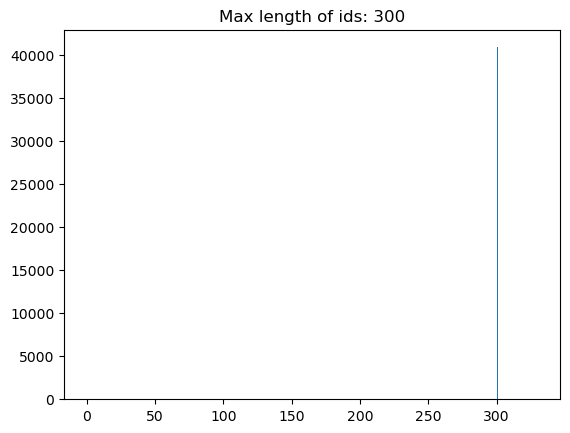

In [14]:
lengths = [len(ids) for (tag, label, ids) in id_to_ids.values()]
maxLen = max(lengths)
plt.hist(lengths, np.linspace(0, int(maxLen*1.1), int(maxLen*1.1) + 1))
plt.ylim(plt.ylim())
maxLen = max(lengths)
# plt.plot([maxLen, maxLen], plt.ylim())
plt.title(f'Max length of ids: {maxLen}')

lengths = [len(ids) for (tag, label, ids) in id_to_ids.values()]
maxLen = max(lengths)
plt.hist(lengths, np.linspace(0, int(maxLen*0.9), int(maxLen*0.9) + 1))
plt.ylim(plt.ylim())
maxLen = max(lengths)
# plt.plot([maxLen, maxLen], plt.ylim())
plt.title(f'Max length of ids: {maxLen}')

MAX_TOKENS = maxLen

In [15]:
def normalize_raw_bbab(bbab, tokenizer_team, std_params, train_mode=True):

    label = []
    if train_mode:
        #---------------------- label, before changing bbab
        for col in _Label_cols:
            start = BBAB_cols.index(col)
            label.append(bbab[start])

    #----------------------- 
    start = BBAB_cols.index(Div_cols[0])
    Div = bbab[start]
    bbab[start] = DIVIISONS.index(Div)  # Assumes no n/a

    start = BBAB_cols.index(Team_cols[0]); end = BBAB_cols.index(Team_cols[-1]) + 1
    pair_str = [str(team) for team in bbab[start : end]]    # Team names are already normalized, removing/striping spaces.
    pair_text = " ".join(pair_str)
    pair_tokens = tokenizer_team.encode(pair_text).ids
    bbab[start : end] = pair_tokens # 0 for Unknown, by tokenizer trainig.

    #--------------------- standardize
    for col in _Cols_to_Standardize:    #   _Cols_to_Standardize has some of BB_cols.
        if not train_mode and col not in BB_cols: continue

        (mean, std, maximum) = std_params[col]
        # assert 0 <= bbab[start]
        start = BBAB_cols.index(col)
        bbab[start] = (bbab[start] - mean) / std
        # assert - mean/std <= bbab[start]
        # assert max(bbab[start : end]) <= (maximum - mean) / std
        # print('std', bbab[start : end])

    #--------------------- columns for positional embedding
    start = BBAB_cols.index(Date_cols[0])   #
    date = bbab[start]
    bbab[start] = (datetime.datetime.combine(date, datetime.time(0,0,0)) - config['baseDate']).days  # either positive or negative

    #---------------------- bb only
    start = BBAB_cols.index(BB_cols[0]); end = start + len(BB_cols)     # 
    bb = bbab[start : end]

    return bbab, bb, label, date

def getDateDetails(date):
    baseYear = config['baseDate'].year
    date_details = tf.Variable([date.year - baseYear, date.month, date.day, date.weekday()], dtype=tf.int32)
    return date_details     # (4,)

filler = tf.zeros_like([0] * len(BBAB_cols), dtype=tf.float32)

def get_data_record(df_total, baseId, ids, tokenizer_team, std_params, train_mode=True):
    # try:
        # base_bbab = list(df_grown.loc[df_grown['id'] == baseId, BBAB_cols])
        if train_mode:
            base_bbab = list(df_total[df_total['id'] == baseId][BBAB_cols].iloc[0, :])  # base_bbab follows BBAB. list
        else:
            base_bbab = list(df_total[df_total['id'] == baseId][BB_cols].iloc[0, :])  # base_bbab follows BB. list

        base_bbab, base_bb, base_label, base_date = normalize_raw_bbab(base_bbab, tokenizer_team, std_params, train_mode=train_mode)
        # base_bbab, base_bb, base_label, base_date
        # print('2', base_bbab)
        baseId = tf.Variable(baseId, dtype=tf.int32)
        base_bbab = tf.Variable(base_bbab, dtype=tf.float32)    # (len(BBAB_cols),)
        base_bb = tf.Variable(base_bb, dtype=tf.float32)        # (len(BB_cols),)
        base_label = tf.Variable(base_label, dtype=tf.float32)  # (len(_Label_cols),)
        # print('3', base_bbab)
        # Default sequence.
        sequence = tf.transpose(tf.Variable([[]] * len(BBAB_cols), dtype=tf.float32))   # (0, len(BBAB_cols))
        # sequence = np.array([[]] * len(BBAB_cols), dtype=config['np_float']).T
        # print('3.5', sequence)
        baseDateDetails = getDateDetails(base_date) # (4,)

        concat = []
        for id in ids:
            bbab = list(df_total[df_total['id'] == id][BBAB_cols].iloc[0, :])   # bbab follows BBAB. list
            # print('4', bbab)
            bbab, _, _, _ = normalize_raw_bbab(bbab, tokenizer_team, std_params, train_mode=train_mode)   # bbab follows BBAB. list
            # check_standardization(bbab, std_params)

            bbab = tf.Variable(bbab, dtype=tf.float32)[tf.newaxis, :]       # (1, len(BBAB_cols))
            # _bbab = bbab[0].numpy()
            # check_standardization(_bbab, std_params)

            concat.append(bbab)     # concat doesn't create a new axis.

        if len(concat) > 0:
            sequence = tf.concat(concat, axis=0)    # (nSequence, len(BBAB_cols))
            # if sequence.shape[0] > 0:
            #     bbab = sequence[0].numpy()
            #     check_standardization(bbab, std_params)

        seq_len_org = sequence.shape[0]
        nMissings = MAX_TOKENS - seq_len_org
        if nMissings > 0:
            patch = tf.stack([filler] * nMissings, axis=0)
            sequence = tf.concat([sequence, patch], axis=0)     # concat doesn't create a new axis. (MAX_TOKENS, len(BBAB_cols))
        base_bb = base_bb[tf.newaxis, :]    # shape: (seq_len = 1, len(BBAB_cols))
        baseDateDetails = baseDateDetails[tf.newaxis, :]
        mask = tf.Variable([1] * seq_len_org + [0] * nMissings, dtype=tf.int32) # (MAX_TOKENS,) ## DO NOT USE tf.constant !!! unstable.
        mask = mask[:, tf.newaxis] & mask[tf.newaxis, :]    # (MAX_TOKENS, MAX_TOKENS)

        return (baseId, sequence, base_bb, base_label, baseDateDetails, mask, seq_len_org)


def generate_dataset_uk(df_total, fixture_id_to_ids, tokenizer_team, std_params, train_mode=True):
    def generator():
        count = 0
        for baseId, (tag, label, ids) in fixture_id_to_ids.items():
            baseId = int(baseId)
            baseId, sequence, base_bb, base_label, baseDateDetails, mask, seq_len_org = get_data_record(df_total, baseId, ids, tokenizer_team, std_params, train_mode=train_mode)
            print("count: {}, baseId: {}".format(count, baseId), end='\r'); count += 1
            
            # if count > 200: break

            yield (baseId, sequence, base_bb, base_label, baseDateDetails, mask, seq_len_org)

    ds = tf.data.Dataset.from_generator(
        generator,
        output_types=(tf.int32, tf.float32, tf.float32, tf.float32, tf.int32, tf.int32, tf.int32),
        output_shapes=(tf.TensorShape(()), tf.TensorShape((MAX_TOKENS, len(BBAB_cols))), tf.TensorShape((1, len(BB_cols),)), tf.TensorShape((len(_Label_cols),)), tf.TensorShape((1, 4)), tf.TensorShape((MAX_TOKENS, MAX_TOKENS)), tf.TensorShape(())),
        args=()
    )
    return ds
    
   
def X_versus_Y(baseId, sequence, base_bb, base_label, baseDateDetails, mask, seq_len_org):
    # target = tf.one_hot(tf.squeeze(tf.cast(base_bbab[:, :, -1], dtype=tf.int32), axis=-1), hParams.target_onehot_size)
    """
    baseId: (). tf.int32
    sequence: (MAX_TOKENS, len(BBAB_cols)). tf.float32
    base_bb: (seq_len = 1, len(BBAB_cols)). tf.float32
    base_label: (len(_Label_cols),). tf.float32
    baseDateDetails: tensor [yy, m, d, wd]
    mask: (MAX_TOKENS, MAX_TOKENS). tf.int32
    seq_len_org: (). tf.int64 ? tf.int32    #-------------------------------------- Check it, though tf.int32 works.
    """
    return (baseId, sequence, base_bb, baseDateDetails, mask), (base_label, seq_len_org)     # (X, Y)

# I found, in PositionalEmbedding, batch size ranges between 3, 4, 6 and 8, while they should be 4 or 8, except margial rows. Check it.
train_batch_size = BATCH_SIZE
test_batch_size = BATCH_SIZE * 2

def apply_train_pipeline(ds):
    return (
        ds
        .shuffle(BUFFER_SIZE)       # Shuffle the training dataset.
        .batch(train_batch_size)
        .map(X_versus_Y, tf.data.AUTOTUNE)
        .cache()
        .prefetch(buffer_size=tf.data.AUTOTUNE)
        )

def apply_test_pipeline(ds):
    return (
        ds
        .batch(test_batch_size)
        .map(X_versus_Y, tf.data.AUTOTUNE)
        .cache()
        .prefetch(buffer_size=tf.data.AUTOTUNE)
        )

In [16]:
std_path = os.path.join(countryDirPath, '_datasets', id_to_ids_filename + '-normalization' + ".json")
std_params = get_standardization_params(df_grown)
print(std_params)
data_helpers.SaveJsonData(std_params, std_path)
std_params = data_helpers.LoadJsonData(std_path)

{'HDA0H': (2.4119683378588057, 1.051541750300173, 21.0), 'HDA0D': (3.4450579422032583, 0.5770603678069028, 15.0), 'HDA0A': (3.6796494375484876, 2.1308711773972195, 46.0), 'HDA1H': (2.4495740157098527, 1.107640269795148, 23.0), 'HDA1D': (3.603998496896818, 0.6490740896637591, 17.0), 'HDA1A': (3.8159252084949564, 2.2283633497565676, 41.0)}


In [17]:
# if TRAIN_MODE:
#     ds_path = os.path.join(countryDirPath, '_datasets', id_to_ids_filename + '-dataset')

#     if os.path.exists(ds_path):
#         ds = tf.data.Dataset.load(ds_path)
#     else:
#         ds = generate_dataset_uk(df_grown, id_to_ids, tokenizer_team, std_params)
#         tf.data.Dataset.save(ds, ds_path)       # This is the true line by which the dataset generator gets to work.
#         ds = tf.data.Dataset.load(ds_path)      # Weird, this line is required. len(ds) would have no value!!!

#     len(ds)

In [18]:
baseIds = [int(id) for (id, value) in id_to_ids.items()]
print(min(baseIds), max(baseIds))

1000001 1041845


In [19]:
if TRAIN_MODE:
    ds_path = os.path.join(countryDirPath, '_datasets', id_to_ids_filename + '-dataset')

    if os.path.exists(ds_path):
        ds = tf.data.Dataset.load(ds_path)
        lastPart = ds.skip(len(ds)-1).take(1)
        lastElem = None; 
        for elem in lastPart: lastElem = elem; break
        (lastId, _, base_bb, _, _, _, _) = lastElem
        lastId = lastId.numpy(); base_bb = base_bb.numpy()
        assert lastId == max(df_grown['id'])
        print("max_id in the existing dataset is {}". format(lastId))
        # print("For your information: base_bb = ", base_bb)
        new_id_to_ids = {key: value for (key, value) in id_to_ids.items() if lastId < int(key)}
        if len(new_id_to_ids) > 0:
            print("{} A dataset of new records are being generated...")
            ds_new = generate_dataset_uk(df_grown, new_id_to_ids, tokenizer_team, std_params)
            print("The dateset is being appended to the exsiting dataset...")
            ds = ds.concatenate(ds_path) # tf.data.Dataset.zip((ds, ds_new))
            tf.data.Dataset.save(ds, ds_path)       # This is the true line by which the dataset generator gets to work.
            ds = tf.data.Dataset.load(ds_path)      # Weird, this line is required. len(ds) would have no value!!!
        else:
            print("No new records generated.")
    else:
        ds = generate_dataset_uk(df_grown, id_to_ids, tokenizer_team, std_params)
        tf.data.Dataset.save(ds, ds_path)       # This is the true line by which the dataset generator gets to work.
        ds = tf.data.Dataset.load(ds_path)      # Weird, this line is required. len(ds) would have no value!!!

    len(ds)

max_id in the existing dataset is 1041845
No new records generated.


In [20]:
total_size = len(ds)

starting_size = int(STARTING_PERCENT/100 * total_size)
ending_size = int(ENDING_PERCENT/100 * total_size)
take_size = total_size - starting_size - ending_size
remaining_ds = ds.skip(starting_size)
dataset = remaining_ds.take(take_size)          # starting | dataset | ending

dataset_size = len(dataset)

train_size = int(TRAIN_PERCENT/100 * dataset_size)
valid_size = int(VALID_PERCENT/100 * dataset_size)
test_size = dataset_size - train_size - valid_size      # len(dataset) = train_size + valid_size + tast_size        NO back_size

train_ds = dataset.take(train_size)                    # dataset[: train_size]
remaining_ds = dataset.skip(train_size - valid_size)    # dataset[train_size - valid_size: ]

back_ds = remaining_ds.take(valid_size)                # dataset[train_size - valid_size: train_size]
remaining_ds = remaining_ds.skip(valid_size)            # dataset[train_size: ]

valid_ds = remaining_ds.take(valid_size)               # dataset[train_size, train_size + valid_size]
test_ds = remaining_ds.skip(valid_size)                # dataset[train_size + valid_size :]

backtest_ds = valid_ds.concatenate(test_ds) # tf.data.Dataset.zip((valid_ds, test_ds))

assert len(test_ds) == test_size

assert dataset_size == len(train_ds) + len(valid_ds) + len(test_ds)

print("total_size, dataset, train_ds, back_ds, valid_ds, test_ds, backtest_ds: ", total_size, len(dataset), len(train_ds), len(back_ds), len(valid_ds), len(test_ds), len(backtest_ds))

total_size, dataset, train_ds, back_ds, valid_ds, test_ds, backtest_ds:  41248 41248 38773 1649 1649 826 2475


In [21]:

train_batches = apply_train_pipeline(train_ds)

In [ ]:
cnt = 5
for z in train_batches:
    (baseId, sequence, base_bb, baseDateDetails, mask), (base_label, seq_len_org) = z
    cnt -= 1 
    if cnt == 0: break
print(baseId.shape, sequence.shape, base_bb.shape, mask.shape, base_label.shape, baseDateDetails.shape, seq_len_org.shape)
sample_x = (sequence, base_bb, baseDateDetails, mask)
sample_y = (base_label, seq_len_org)
# print(baseId.numpy(), base_bb.numpy(), baseDateDetails.numpy()) 

In [ ]:
back_batches = apply_test_pipeline(back_ds)
valid_batches = apply_test_pipeline(valid_ds)
test_batches = apply_test_pipeline(test_ds)
backtest_batches = apply_test_pipeline(backtest_ds)

In [ ]:
def positional_encoding(positions, d_model):     # positions.shape = (batch, seq_len). d_model is a positive even integer.
    # positions[b, :] = [dago_299, dago_298, ..., dago_0] = eg [6, 7, ..., 1611]

    years = 25
    quotient = 365 * years / d_model   # 325 * 25 is total days during 25 years since 2024 (the earliest data year). 
    fractional_pos = positions / quotient  # (batch, seq_len). max << d_model.  lower=0, upper<<d_model
    depth = d_model/2   #
    depths = tf.range(depth, dtype=tf.float32) / depth  # (depth,). [0/depth, 1/depth, ..., (depth-1)/depth]

    # Why do we use this specific formula for depths, while any formula will work?
    # depths will be multiplied by fractional_pos, which may have ever large number.
    # We want the product to be limited, and depths should converge to zero to limit the product.
    # If it cenverges to zero too fast, though, the generated pos_encoding will have little representative power as positional representation.
    # Why, then, do we want to limit the product?
    # The product visiting many different values will be enough for us. The solution is to let them go to zero, from a significant value.
    BIG = d_model * 1.0 * 0.8     # let it be float.
    depths = 1.0 / tf.pow(BIG, depths)        # 1 / [1, ..., BIG ** ((depth-1)/depth)] = [1, ..., >1/BIG]

    # Why fractional_pos is multiplied linearly?
    # Because (sin(A+a), cos(A+a)) is a rotation of (sin(A), cos(A)), no matter what depths is.
    angle_rads = fractional_pos[:, :, tf.newaxis] * depths  # [0, ..., <<d_model ] * [ 1, ..., >1/BIG]. 
    # Interleaving sin and cos is equivalent to seperated sin and cos.
    # pos_encoding = rearrange([tf.math.sin(angle_rads), tf.math.cos(angle_rads)], 'w b p d -> w h (w t)')  # Interleaving sin and cos. (batch, seq_len, d_model)
    pos_encoding = tf.concat([tf.math.sin(angle_rads), tf.math.cos(angle_rads)], axis=-1)   # Seperated sin and cos. (batch, seq_len, d_model)
    return pos_encoding  # (batch, seq_len, d_model)

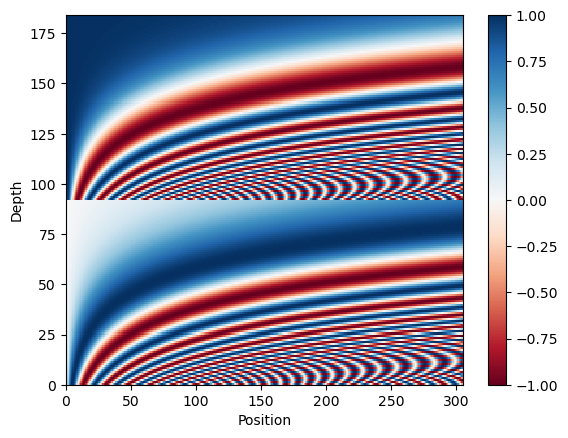

In [ ]:
years = 15
seq_len = 300
d_model = 184
positions = tf.Variable([[i for i in range(0, 365 * years, int(365 * years / seq_len))] for batch in range(100)], dtype=tf.float32)
# positions = tf.ones((100, 200), dtype=tf.float32) * tf.range(200, dtype=tf.float32)
pos_encoding = positional_encoding(positions, d_model=d_model)
# print('pos_encoding', pos_encoding.shape)
pos_encoding = pos_encoding[0, :, :]
# print(pos_encoding.shape)
# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [ ]:

class hParams:    
    nDivisions = len(DIVIISONS)
    division_embs = 4

    nTeams = tokenizer_team.get_vocab_size()    # including Unknown
    team_embs = TEAM_EMBS
    nGoals  = 4  # [0, 1, 2, 3] Maximum nGoals goals for a team in each of 1st and 2nd halfs. Extra goals will be clipped_by_value.
    goal_embs = 4
    nShoots = 21    # [0, ..., 20]
    shoot_embs = 4 # for combination
    nShootTs = 11   # [0, ..., 10]
    shootT_embs = 4 # for combination
    nCorners = 11   # [0, ..., 10]
    corner_embs = 4 # for combination
    nFauls = 21     # [0, ..., 20]
    faul_embs = 2 # for combination
    nYellows = 5    # [0, ..., 4]
    yellow_embs = 2 # for combination
    nReds = 2       # [0, 1]
    red_embs = 2
    
    batch_size = BATCH_SIZE
    days_spanning_years = 30
    num_layers = TRANSFORMER_LAYERS
    num_heads = TRANSFORMER_HEADS
    m365_size = 1
    initial_m365 = 0.9

    """
    if self.encoder:
        if EMBED_AB_COLS:
                self.firstH_goal_emb = tf.keras.layers.Embedding(hParams.nGoals * hParams.nGoals, hParams.goal_embs, dtype=tf.float32, mask_zero=False) # Learn goals 0
                self.secondH_goal_emb = tf.keras.layers.Embedding(hParams.nGoals * hParams.nGoals, hParams.goal_embs, dtype=tf.float32, mask_zero=False) # Learn goals 0
                self.result_emb = tf.keras.layers.Embedding(hParams.nResult, hParams.result_embs, dtype=tf.float32, mask_zero=False) # Learn Unknown
                self.shoot_emb = tf.keras.layers.Embedding(hParams.nShoots * hParams.nShoots, hParams.shoot_embs, dtype=tf.float32, mask_zero=False)
                self.shootT_emb = tf.keras.layers.Embedding(hParams.nShootTs * hParams.nShootTs, hParams.shootT_embs, dtype=tf.float32, mask_zero=False)
                self.corner_emb = tf.keras.layers.Embedding(hParams.nCorners * hParams.nCorners, hParams.corner_embs, dtype=tf.float32, mask_zero=False)
                self.faul_emb = tf.keras.layers.Embedding(hParams.nFauls * hParams.nFauls, hParams.faul_embs, dtype=tf.float32, mask_zero=False)
                self.yellow_emb = tf.keras.layers.Embedding(hParams.nYellows * hParams.nYellows, hParams.yellow_embs, dtype=tf.float32, mask_zero=False)
                self.red_emb = tf.keras.layers.Embedding(hParams.nReds * hParams.nReds, hParams.red_embs, dtype=tf.float32, mask_zero=False)

            first_half_goals = self.combined_embeddings_of_double_columns(self.firstH_goal_emb, half_goals, hParams.nGoals)
            second_half_goals = self.combined_embeddings_of_double_columns(self.secondH_goal_emb, full_goals - half_goals, hParams.nGoals)
            shoot = self.combined_embeddings_of_double_columns(self.shoot_emb, shoot, hParams.nShoots)
            shootT = self.combined_embeddings_of_double_columns(self.shootT_emb, shootT, hParams.nShootTs)
            corner = self.combined_embeddings_of_double_columns(self.corner_emb, corner, hParams.nCorners)
            faul = self.combined_embeddings_of_double_columns(self.faul_emb, shoot, hParams.nFauls)
            yellow = self.combined_embeddings_of_double_columns(self.yellow_emb, yellow, hParams.nYellows)
            red = self.combined_embeddings_of_double_columns(self.red_emb, red, hParams.nReds)

            concat = [div, teams, odds, first_half_goals, second_half_goals, shoot, shootT, corner, faul, yellow, red]
        else:
            concat = [div, teams, odds, half_goals, full_goals, shoot, shootT, corner, faul, yellow, red]
    else:
        bYears, bMonths, bDays, bWDays = self.representDateDetails(baseDateDetails)
        concat = [div, teams, odds, bYears, bMonths, bDays, bWDays]  #

            """
    # d_model DEPENDS...
    # We want as small d_model as possible, because from which we can freely choose an actual d_model.
    # Tests seem to indicate that larger d_model leads to training overfitting and validation underfitting.
    d_model = 1 * division_embs + 2 * team_embs + 3 * NUMBER_BOOKIES
    d_encoder = d_decoder = 0
    if EMBED_AB_COLS:
        d_encoder = d_model + 1 * goal_embs + 1 * goal_embs + 1 * (shoot_embs + shootT_embs + corner_embs + faul_embs + yellow_embs + red_embs)
        d_decoder = d_model + 2 * 4     # 2 * 4 : date details
    else:   # This mode, EMBED_AB_COLS = False, gives much smaller d_moddel, maybe avoiding overfitting.
        d_encoder = d_model + 2 * 8     # 2 * 8 : bb_cols
        d_decoder = d_model + 2 * 4     # 2 * 4 : date details
    d_model = max(d_encoder, d_decoder)     # (136, 118) for EMBED_AB_COLS, (126, 118) for False EMBED_AB_COLS
    d_model += ADDITIONAL_D_MODEL               # Adjust for the model size and overfitting.
    d_model = d_model + d_model % 2     # make it an even number.
    print("d_model: ", d_model)

d_model:  136


In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):

    def __init__(self, hParams, isEncoder=True):
        super().__init__()
        self.isEncoder = isEncoder

        # game
        self.division_emb = tf.keras.layers.Embedding(hParams.nDivisions, hParams.division_embs, dtype=tf.float32, mask_zero=False) # Learn Unknown
        self.team_emb = tf.keras.layers.Embedding(hParams.nTeams, hParams.team_embs, dtype=tf.float32, mask_zero=False) # Learn Unknown

        if EMBED_AB_COLS:
            # AB_cols
            self.firstH_goal_emb = tf.keras.layers.Embedding(hParams.nGoals * hParams.nGoals, hParams.goal_embs, dtype=tf.float32, mask_zero=False)
            self.secondH_goal_emb = tf.keras.layers.Embedding(hParams.nGoals * hParams.nGoals, hParams.goal_embs, dtype=tf.float32, mask_zero=False)
            self.shoot_emb = tf.keras.layers.Embedding(hParams.nShoots * hParams.nShoots, hParams.shoot_embs, dtype=tf.float32, mask_zero=False)
            self.shootT_emb = tf.keras.layers.Embedding(hParams.nShootTs * hParams.nShootTs, hParams.shootT_embs, dtype=tf.float32, mask_zero=False)
            self.corner_emb = tf.keras.layers.Embedding(hParams.nCorners * hParams.nCorners, hParams.corner_embs, dtype=tf.float32, mask_zero=False)
            self.faul_emb = tf.keras.layers.Embedding(hParams.nFauls * hParams.nFauls, hParams.faul_embs, dtype=tf.float32, mask_zero=False)
            self.yellow_emb = tf.keras.layers.Embedding(hParams.nYellows * hParams.nYellows, hParams.yellow_embs, dtype=tf.float32, mask_zero=False)
            self.red_emb = tf.keras.layers.Embedding(hParams.nReds * hParams.nReds, hParams.red_embs, dtype=tf.float32, mask_zero=False)

        # base_date
        self.day_emb = tf.keras.layers.Embedding(31, 2, dtype=tf.float32, mask_zero=False)
        self.month_emb = tf.keras.layers.Embedding(12, 2, dtype=tf.float32, mask_zero=False)
        self.wday_emb = tf.keras.layers.Embedding(7, 2, dtype=tf.float32, mask_zero=False)

        self.position_permuting_encoding = tf.keras.layers.Dense(hParams.d_model)
        self.position_permuting_decoding = tf.keras.layers.Dense(hParams.d_model)

        self.idx_Days = BB_cols.index('Date')

    def representDateDetails(self, dateDetails):
        # dateDetails: (batch, 1, 4)
        bYears, bMonths, bDays, bWDays = tf.split(dateDetails, [1, 1, 1, 1], axis=-1)   # All should be of (batch, seq_len = 1, 1)
        bYears = tf.cast(bYears, dtype=tf.float32)  # (batch, seq_len = 1, 1)
        bDays = self.day_emb(bDays)[:, :, -1]       # (batch, seq_len = 1, embs = 2)
        bMonths = self.month_emb(bMonths)[:, :, -1] # (batch, seq_len = 1, embs = 2)
        bWDays = self.wday_emb(bWDays)[:, :, -1]    # (batch, seq_len = 1, embs = 2)
        # w = tf.Variable(np.math.pi / 25, dtype=tf.float32)    # 25 years are covered by pi or a half circle.
        w = np.math.pi / 25
        bYearsCos = tf.math.cos(bYears * w)
        bYearsSin = tf.math.sin(bYears * w)
        bYears = tf.concat([bYearsCos, bYearsSin], axis=-1)   # (batch, seq_len = 1, 1+1 = 2)
        return bYears, bMonths, bDays, bWDays

    def combined_embeddings_of_double_columns(self, emb_layer, columns, nValues):
        # Assume emb_layer = Embedding(nValues * nValues, embs, mask_zero=False)
        cols = tf.cast(columns, dtype=tf.int32)
        cols = tf.clip_by_value(cols, 0, nValues-1)
        combi = cols[:, :, 0] * nValues + cols[:, :, 1]   # (batch, seq_len, 1). [0, ..., nValues * nValues - 1]
        combi = emb_layer(combi)
        return combi    # (batch, seq_len, 1)

    def call(self, x):
        (sequence, base_bb, baseDateDetails, mask) = x # sob = sequence or base_bb
        sequenceDays = sequence[:, :, self.idx_Days]  # (batch, seq_len)
        baseDays = base_bb[:, :, self.idx_Days]   # (batch, 1)

        # sequence follows BBAB, whereas base_bb follows 
        
        # BB_cols = id_cols + Div_cols + Date_cols + Team_cols + Odds_cols
        # AB_cols = Goal_cols + Result_cols + Shoot_cols + ShootT_cols + Corner_cols + Faul_cols + Yellow_cols + Red_cols

        if self.isEncoder:
            # ramainder: Shoot_cols + ShootT_cols + Corner_cols + Faul_cols + Yellow_cols + Red_cols  --- total 12 fields.
            id, div, days, teams, odds, half_goals, full_goals, shoot, shootT, corner, faul, yellow, red \
            = tf.split(sequence, [len(id_cols), len(Div_cols), len(Date_cols), len(Team_cols), len(Odds_cols), len(Half_Goal_cols), len(Full_Goal_cols), \
                                  len(Shoot_cols), len(ShootT_cols), len(Corner_cols), len(Faul_cols), len(Yellow_cols), len(Red_cols),], axis=-1)
            # All shape of (batch, sequence, own_cols), all tf.flaot32
        else:
            id, div, days, teams, odds, remainder \
            = tf.split(base_bb, [len(id_cols), len(Div_cols), len(Date_cols), len(Team_cols), len(Odds_cols), -1], axis=-1)  
            # remainder: [] 
            # All shape of (batch, 1, own_cols), guess., all tf.float32

        div = self.division_emb(tf.cast(div, dtype=tf.int32))   # (batch, MAX_TOKENS or 1, columns=1, division_embs)
        div = tf.reshape(div, [div.shape[0], div.shape[1], -1]) # (batch, MAX_TOKENS or 1, extended_columns=1*division_embs) --- 
        teams = self.team_emb(tf.cast(teams, dtype=tf.int32))   # (batch, MAX_TOKENS or 1, columns=2, team_embs)
        teams = tf.reshape(teams, [teams.shape[0], teams.shape[1], -1]) # (batch, MAX_TOKENS or 1, extended_columns=2*team_embs) --- 

        if self.isEncoder:
            if EMBED_AB_COLS:
                first_half_goals = self.combined_embeddings_of_double_columns(self.firstH_goal_emb, half_goals, hParams.nGoals)
                second_half_goals = self.combined_embeddings_of_double_columns(self.secondH_goal_emb, full_goals - half_goals, hParams.nGoals)
                shoot = self.combined_embeddings_of_double_columns(self.shoot_emb, shoot, hParams.nShoots)
                shootT = self.combined_embeddings_of_double_columns(self.shootT_emb, shootT, hParams.nShootTs)
                corner = self.combined_embeddings_of_double_columns(self.corner_emb, corner, hParams.nCorners)
                faul = self.combined_embeddings_of_double_columns(self.faul_emb, shoot, hParams.nFauls)
                yellow = self.combined_embeddings_of_double_columns(self.yellow_emb, yellow, hParams.nYellows)
                red = self.combined_embeddings_of_double_columns(self.red_emb, red, hParams.nReds)

                concat = [div, teams, odds, first_half_goals, second_half_goals, shoot, shootT, corner, faul, yellow, red]
            else:
                concat = [div, teams, odds, half_goals, full_goals, shoot, shootT, corner, faul, yellow, red]
        else:
            if DECODE_BASE_DATE:
                bYears, bMonths, bDays, bWDays = self.representDateDetails(baseDateDetails)
                concat = [div, teams, odds, bYears, bMonths, bDays, bWDays]
            else:
                concat = [div, teams, odds]

        concat = tf.concat(concat, axis=-1)
        assert concat.shape[-1] <= hParams.d_model  
        
        if self.isEncoder:
            concat = self.position_permuting_encoding(concat)  # (batch, MAX_TOKENS, <= hParams.d_model)
        else:
            concat = self.position_permuting_decoding(concat)  # (batch, 1, <= hParams.d_model)

        positions = tf.cast(baseDays - sequenceDays, dtype=tf.float32) if self.isEncoder else tf.cast(baseDays - baseDays, dtype=tf.float32) # the latter is a zero tensor.
        # eg. positions[b, :] = Tensor([6, 7, ..., 1911]
        pe = positional_encoding(positions, d_model=hParams.d_model) # (batch, MAX_TOKENS or 1, hParams.d_model)
        pe = pe / tf.math.sqrt(tf.cast(concat.shape[-1], tf.float32))   # Read "Attention is all you need"
        concat = concat + pe

        if self.isEncoder:
            mask = mask     # (batch, MAX_TOKEN, MAX_TOKEN)
        else:
            # Decoder layers will find cross attention between Decoder concat and Encoder concat.
            mask = mask[:, 0:concat.shape[1], :]    # concat: (batch, 1, MAX_TOKEN)   

        return (concat, mask)


In [ ]:
PE = PositionalEmbedding(hParams, isEncoder=True)
eSob, eMask = PE(sample_x)
print(eSob.shape, eMask.shape )
del PE

(8, 300, 136) (8, 300, 300)


In [ ]:
PE = PositionalEmbedding(hParams, isEncoder=False)
dSob, dMask = PE(sample_x)
print(dSob.shape, dMask.shape )
del PE

(8, 1, 136) (8, 1, 300)


In [ ]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
      super().__init__()
      self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
      self.layernorm = tf.keras.layers.LayerNormalization()   # So the default -1 axis is normalized across. No inter-token operation.
      self.add = tf.keras.layers.Add()  # Operate on the -1 axis.

class CrossAttention(BaseAttention):
    def call(self, x, context, mask):
      attn_output, attn_scores = self.mha(query=x, key=context, value=context, attention_mask=mask, return_attention_scores=True)    
      self.last_attn_scores = attn_scores
      x = self.add([x, attn_output])
      x = self.layernorm(x)
      return x
  
class GlobalSelfAttention(BaseAttention): 
    def call(self, x, mask):
      attn_output = self.mha(query=x, value=x, key=x, attention_mask=mask)
      x = self.add([x, attn_output])
      x = self.layernorm(x)
      return x
  
class CausalSelfAttention(BaseAttention): # mask-agnostic
    def call(self, x):
      attn_output = self.mha(query=x, value=x, key=x, use_causal_mask = True)  # look-over mask is generagted and used, in decoder layers
      x = self.add([x, attn_output])
      x = self.layernorm(x)
      return x
  
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
      super().__init__()
      self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model),    # across -1 axis
        tf.keras.layers.Dropout(dropout_rate)    # mask-agnostic
      ])
      self.add = tf.keras.layers.Add()
      self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
      x = self.add([x, self.seq(x)])
      x = self.layer_norm(x)
      return x
  
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
      super().__init__()

      self.self_attention = GlobalSelfAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)
      self.ffn = FeedForward(d_model, dff)

    def call(self, x, mask):
      # x: (batch, max_tokens, d_model), mask: (batch, max_tokens, max_tokens)
      x = self.self_attention(x, mask)
      x = self.ffn(x)
      return x
  
class Encoder(tf.keras.layers.Layer):
    def __init__(self, hParams, dropout_rate=0.1):
      super().__init__()
      self.d_model = hParams.d_model
      self.num_layers = hParams.num_layers
      self.pos_emb = PositionalEmbedding(hParams, isEncoder=True)
      self.dropout = tf.keras.layers.Dropout(dropout_rate)
      self.enc_layers = [
          EncoderLayer(d_model=hParams.d_model, num_heads=hParams.num_heads, dff=hParams.d_model * 4, dropout_rate=dropout_rate)
          for _ in range(hParams.num_layers)]

    def call(self, x):
      # x = (sequence, base_bb, baseDateDetails, mask)
      # x[0]: (batch, max_tokens, bbab.len), x[1]: (batch, 1, bb.len), x[2]: (batch, 1, 4), x[3]: (batch, max_tokens, max_tokens)
      x, mask = self.pos_emb(x)  # x: (batch, max_tokens, d_model), mask: (batch, max_tokens, max_tokens)
      x = self.dropout(x)
      for encoder_layer in self.enc_layers:
        x = encoder_layer(x, mask)
      return x  # (batch_size, max_tokens, d_model)
  
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
      super(DecoderLayer, self).__init__()
      self.causal_self_attention = CausalSelfAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)
      self.cross_attention = CrossAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)
      self.ffn = FeedForward(d_model, dff)

    def call(self, x, context, cross_attention_mask):
      # x: (batch, 1, d_model), context: (batch, max_tokens, d_mode)
      x = self.causal_self_attention(x=x)
      x = self.cross_attention(x, context, cross_attention_mask)
      self.last_attn_scores = self.cross_attention.last_attn_scores
      x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
      return x
  
class Decoder(tf.keras.layers.Layer):
    def __init__(self, hParams, dropout_rate=0.1):
      super(Decoder, self).__init__()
      self.d_model = hParams.d_model
      self.num_layers = hParams.num_layers
      self.pos_emb = PositionalEmbedding(hParams, isEncoder=False)
      self.dropout = tf.keras.layers.Dropout(dropout_rate)
      self.dec_layers = [
          DecoderLayer(d_model=hParams.d_model, num_heads=hParams.num_heads, dff=hParams.d_model * 4, dropout_rate=dropout_rate)
          for _ in range(hParams.num_layers)]
      self.last_attn_scores = None

    def call(self, x, context):
      # x = (sequence, base_bb, baseDateDetails, mask)
      # x[0]: (batch, max_tokens, bbab.len), x[1]: (batch, 1, bb.len), x[2]: (batch, 1, 4), x[3]: (batch, max_tokens, max_tokens)
      # context: (batch, max_tokens, d_model)
      # `x` is token-IDs shape (batch, target_seq_len)
      x, ca_mask = self.pos_emb(x)  # x: (batch, 1, d_model), ca_mask: (batch, 1, max_tokens), ca_cask: which tokens of context to mask out (with 0)
      x = self.dropout(x)
      for decoder_layer in self.dec_layers:
        x  = decoder_layer(x, context, ca_mask)
      self.last_attn_scores = self.dec_layers[-1].last_attn_scores
      return x
  
class Transformer(tf.keras.Model):
    def __init__(self, hParams, dropout_rate=0.1):
      super().__init__()
      self.encoder = Encoder(hParams, dropout_rate=dropout_rate)
      self.decoder = Decoder(hParams, dropout_rate=dropout_rate)
      self.final_layer = tf.keras.layers.Dense(hParams.d_model) #-------------- to modify

    def call(self, x):
      # inputs = (sequence, base_bb, baseDateDetails, mask)
      # sequence: (batch, max_token, aabb), base: (batch, 1, bb), baseDateDetails: (batch, 1, 4), mask: (batch, max_token, max_token)
      context = self.encoder(x)  # (batch, max_tokens, d_model). Only sequence and mask are used.
      x = self.decoder(x, context)  # (batch, 1, d_model).  Only base_bb, baseDateDetails, and mask are used.
      logits = self.final_layer(x)  # (batch, 1, d_model)
      logits = tf.squeeze(logits, axis=-2)  # (batch, d_model)
      return logits

In [ ]:
sample_transformer = Transformer(hParams)
y = sample_transformer(sample_x)

sample_transformer.summary()
del sample_transformer

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  27705236  
                                                                 
 decoder (Decoder)           multiple                  54482656  
                                                                 
 dense_32 (Dense)            multiple                  18632     
                                                                 
Total params: 82,206,524
Trainable params: 82,206,524
Non-trainable params: 0
_________________________________________________________________


In [ ]:
"""
I don't choose using Normalization layers for Adopters because the previous sub-network, the Transformer, has lots of 
Normalization layers and an Adapter is of trivial size compared to the previous sub-network.
"""

# Used for earlier versions that don't allow mixing bookies.
class Adaptor(tf.keras.layers.Layer):
  def __init__(self, nLayers, d_output, dropout_rate=0.1):
    super().__init__()
    dims = [hParams.d_model * 2] * nLayers
    dims = dims + [hParams.d_model * 2 + round( (d_output - hParams.d_model * 2) * (layer+1) / (nLayers) ) for layer in range(nLayers)]
    layers = [tf.keras.layers.Dense(dim, kernel_initializer=tf.keras.initializers.LecunUniform(), activation='relu') for dim in dims]
    self.seq = tf.keras.Sequential(layers)
  def call(self, x):
    x = self.seq(x)
    return x
  
class MixedAdaptor(tf.keras.layers.Layer):
  def __init__(self, nLayers, d_output, dropout_rate=0.1):
    super().__init__()
    dims = [hParams.d_model * 2] * nLayers
    dims = dims + [hParams.d_model * 2 + round( (d_output - hParams.d_model * 2) * (layer+1) / (nLayers) ) for layer in range(nLayers)]
    layers = [tf.keras.layers.Dense(dim, kernel_initializer=tf.keras.initializers.LecunUniform(), activation='relu') for dim in dims]
    self.seq = tf.keras.Sequential(layers)
  def call(self, x):
    x = self.seq(x)
    return x

class BaseAdaptor(tf.keras.layers.Layer):
  def __init__(self, nLayers, d_output, dropout_rate=0.1):
    super().__init__()
    dims = [hParams.d_model] * nLayers + [hParams.d_model + round( (d_output - hParams.d_model) * (layer+1) / (nLayers) ) for layer in range(nLayers)]
    layers = [tf.keras.layers.Dense(dim, activation='relu') for dim in dims]
    self.seq = tf.keras.Sequential(layers)
  def call(self, x):
    x = self.seq(x)
    return x

class OhAdaptor(tf.keras.layers.Layer):
  def __init__(self, nLayers, d_output, dropout_rate=0.1):
    super().__init__()
    dims = [d_output] * nLayers
    layers = [tf.keras.layers.Dense(dim, activation='relu') for dim in dims]
    self.seq = tf.keras.Sequential(layers)
  def call(self, x):
    x = self.seq(x)
    return x

In [ ]:
class Model_1X2(tf.keras.Model):
    softmax = tf.keras.layers.Softmax(axis=-1)

    def __init__(self, hParams, nQueries, dropout_rate=0.1):
        super().__init__()
        self.nQueries = nQueries
        self.transformer = Transformer(hParams, dropout_rate=dropout_rate)
        #   self.bookies = ['B365', 'Betfair', 'Interwetten', 'William']
        self.bookies = ['HDA' + str(b) for b in range(NUMBER_BOOKIES)]
        self.baseAdaptors = [Adaptor(ADAPTORS_LAYERS, self.nQueries) for _ in self.bookies]
        return

    def call(self, x):
        x = self.transformer(x) # (batch, d_model)
        stake_p = [adaptor(x) for adaptor in self.baseAdaptors]  # [(batch, nQueries)] * nBookies
        stake_p = tf.stack(stake_p, axis=0)   # (nBookies, batch, nQueries)
        stake_p = Model_1X2.softmax(stake_p)  # (nBookies, batch, nQueries)
        return stake_p
    
    def h_true(self, ftGoals):  # Defines this QGroup. This is for 1X2 QGroup. Derived classes re-define this funciton.
        # ftGoals:  (batch, 2)
        ftGoals = tf.cast(ftGoals, dtype=tf.int32)  # (batch, 2)
        h = (tf.math.greater(ftGoals[..., 0], ftGoals[..., 1]), tf.math.equal(ftGoals[..., 0], ftGoals[..., 1]), tf.math.less(ftGoals[..., 0], ftGoals[..., 1]))
        h = tf.cast(tf.transpose(h), dtype=tf.float32)  # (batch, nQueries)
        return h

    def loss(self, y, output):   
        # y: (batch, len(Team_cols)+len(Odds_cols)) 
        # output: (nBookies, batch, nQueries)
        ftGoals, odds = tf.split(y, [2, -1], axis=-1) # (batch, 2), (batch, self.nQueries * len(self.bookies))
        odds = tf.split(odds, [self.nQueries] * len(self.bookies), axis=-1)  # [(batch, nQueries)] * nBookies
        odds = tf.stack(odds, axis=0)  # (nBookies, batch, nQueries)
        happen_t = self.h_true(ftGoals) # (batch, nQueries)
        oh = tf.math.multiply(odds, happen_t)   # (nBookies, batch, nQueries)
        (stake_p) = output

        # -----------------------------------------------------------------------------------------
        # Note: happen_p and stake_p are not converted to one-hot values, unlike they should.
        #------------------------------------------------------------------------------------------
        
        profit_backtest = tf.reduce_mean(tf.reduce_sum(tf.math.multiply(oh - 1.0, stake_p), axis=-1), axis=None)  # () 
        loss = - profit_backtest  # U.action.42
    
        return loss # (), negative average profit on a game on a bookie
    
    def backtest(self, y, output, profit_keys):
        # y: (batch, len(Team_cols)+len(Odds_cols)) 
        # output: (nBookies, batch, nQueries)
        ftGoals, odds = tf.split(y, [2, -1], axis=-1) # (batch, 2), (batch, self.nQueries * len(self.bookies))
        odds = tf.split(odds, [self.nQueries] * len(self.bookies), axis=-1)  # [(batch, nQueries)] * nBookies
        odds = tf.stack(odds, axis=0)  # (nBookies, batch, nQueries)
        happen_t = self.h_true(ftGoals) # (batch, nQueroes)
        oh = tf.math.multiply(odds, happen_t)   # (nBookies, batch, nQueries)
        (stake_p) = output

        # -----------------------------------------------------------------------------------------
        # Note: oh_p and stake_p are not converted to one-hot values, unlike they should.
        #------------------------------------------------------------------------------------------
        profit_p = tf.math.reduce_sum(tf.math.multiply(odds * stake_p - 1.0, stake_p), axis=-1)  # (nBookies, batch)
        profit_backtest = tf.math.reduce_sum(tf.math.multiply(oh - 1.0, stake_p), axis=-1)  # (nBookies, batch)

        profit_list = []; cast_list = []
        profit = MIN_PROFIT
        for profit_key in profit_keys:
            best_profit_backtest = profit_backtest[profit_p >= profit_key]  # (nChosenProfits,)
            cast = best_profit_backtest.shape[-1]
            if cast > 0: profit = tf.math.reduce_mean(best_profit_backtest)
            profit_list.append(float(profit))
            cast_list.append(cast)
        return profit_list, cast_list
    
    def backtest_event_wise(self, y, output, key_a, key_b):
        # y: (batch, len(Team_cols)+len(Odds_cols)) 
        # output: (nBookies, batch, nQueries)
        ftGoals, odds = tf.split(y, [2, -1], axis=-1) # (batch, 2), (batch, self.nQueries * len(self.bookies))
        odds = tf.split(odds, [self.nQueries] * len(self.bookies), axis=-1)  # [(batch, nQueries)] * nBookies
        odds = tf.stack(odds, axis=0)  # (nBookies, batch, nQueries)
        happen_t = self.h_true(ftGoals) # (batch, nQueroes)
        oh = tf.math.multiply(odds, happen_t)   # (nBookies, batch, nQueries)
        (stake_p) = output

        # -----------------------------------------------------------------------------------------
        # Note: oh_p and stake_p are not converted to one-hot values, unlike they should.
        #------------------------------------------------------------------------------------------
        profit_p = tf.math.reduce_sum(tf.math.multiply(odds * stake_p - 1.0, stake_p), axis=-1)  # (nBookies, batch)
        profit_backtest = tf.math.reduce_sum(tf.math.multiply(oh - 1.0, stake_p), axis=-1)  # (nBookies, batch)
        
        condition = tf.math.logical_and(key_a <= profit_p, profit_p < key_b)   # (nBookies, batch), dtype=tf.bool
        indices = tf.where(condition)   # tf.Valuse([ [b1, g1], [b2, g2], ..., [bn, gn]], dtype=tf.int64)
        profits_backtest = profit_backtest[condition]  # (n,), tf.Variable([p1, p2, ..., pn])
        # tf.Variable([ [b1, g1], [b2, g2], ..., [bn, gn]], dtype=tf.int64)
        # (n,), tf.Values([p1, p2, ..., pn])
        return indices, profits_backtest

In [ ]:
model_1x2 = Model_1X2(hParams, nQueries=3, dropout_rate=DROPOUT)

stake_p = model_1x2(sample_x, training=True)
loss = model_1x2.loss(sample_y[0], stake_p)

profits, casts = model_1x2.backtest(sample_y[0], stake_p, PROFIT_KEYS)
# print(profit_list)
# print(nBettings_list)

model_1x2.summary()

Model: "model_1x2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer_1 (Transformer)  multiple                 82206524  
                                                                 
 adaptor (Adaptor)           multiple                  953683    
                                                                 
 adaptor_1 (Adaptor)         multiple                  953683    
                                                                 
Total params: 84,113,890
Trainable params: 84,113,890
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tf.keras.utils.plot_model(model_1x2, show_shapes=True, dpi=48)

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction='none')

def masked_loss_uk(label, y_pred):
  # lable = (target(batch, 3), base_bb(batch, 1, 9), seq_len(batch, 1)), y_pred: (batch, 3)
  y_true = label[0]   # one_hot: (batch, 3)
  seq_len = label[2]  # (batch, 1)

  mask = y_true != 0 
  loss = loss_object(y_true, y_pred)
  mask = tf.cast(mask, dtype=loss.dtype)
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask) # eq. sum_loss / batch
  return loss


class recall():
  def __init__(self, name='recall', min_seq_len=5, **kwargs):
    self.min_seq_len = min_seq_len
    self.n = None
    self.recall = None
    self.reset()

  def update_state(self, label, y_pred):
    # lable = (target(batch, 3), base_bb(batch, 1, 9), seq_len(batch,)), y_pred: (batch, 3)
    y_true = label[0]   # one_hot: (batch, 3)
    seq_len = label[2]  # (batch)

    seq_len_mask = tf.cast(seq_len >= self.min_seq_len, dtype=tf.float32)[:, tf.newaxis, tf.newaxis]
    y_true = y_true * seq_len_mask
    y_pred = y_pred * seq_len_mask 

    # print('recall', y_true.shape, y_pred.shape, seq_len_mask.shape)

    true_positives = tf.math.reduce_sum(y_true * y_pred)
    # print('recall', true_positives.numpy())
    possible_positives = tf.math.reduce_sum(y_true)
    recall_keras = true_positives / (possible_positives + 1e-9) #tf.keras.backend.epsilon())
    self.n += 1
    self.recall = self.recall * (self.n-1)/self.n + recall_keras.numpy() / self.n


  def result(self):
    return self.recall
  
  def reset(self):
    self.n = 0
    self.recall = 0.0
  
recall_object = recall(min_seq_len=5)

class precision():
  def __init__(self, name='precision', min_seq_len=5, **kwargs):
    self.min_seq_len = min_seq_len
    self.n = None
    self.precision = None
    self.reset()

  def update_state(self, label, y_pred):
    # lable = (target(batch, 3), base_bb(batch, 1, 9), seq_len(batch,)), y_pred: (batch, 3)
    y_true = label[0]   # one_hot: (batch, 3)
    seq_len = label[2]  # (batch, 1)

    seq_len_mask = tf.cast(seq_len >= self.min_seq_len, dtype=tf.float32)[:, tf.newaxis, tf.newaxis]
    y_true = y_true * seq_len_mask
    y_pred = y_pred * seq_len_mask 

    true_positives = tf.math.reduce_sum(y_true * y_pred)
    predicted_positives = tf.math.reduce_sum(y_pred)
    precision_keras = true_positives / (predicted_positives + 1e-9) #tf.keras.backend.epsilon())
    self.n += 1
    self.precision = self.precision * (self.n-1)/self.n + precision_keras.numpy() / self.n

  def result(self):
    return self.precision
  
  def reset(self):
    self.n = 0
    self.precision = 0.0

precision_object = precision(min_seq_len=5)

In [ ]:
# @tf.function  #-------------------- Weird: no work.
def backtest_with_dataset(dataset, profit_keys):
    profits = [MIN_PROFIT] * len(profit_keys)
    casts = [0] * len(profit_keys)
    for step, ((baseId, sequence, base_bb, baseDateDetails, mask), (base_label, seq_len_org)) in enumerate(dataset):
        x = (sequence, base_bb, baseDateDetails, mask); y = base_label

        outputs = model_1x2(x, training=False)  #
        profit_list, cast_list = model_1x2.backtest(y, outputs, profit_keys)

        for p, c, id in zip(profit_list, cast_list, range(len(profit_keys))):
            if c > 0:
                profits[id] = (profits[id] * casts[id] + p * c) / (casts[id] + c)
                casts[id] = casts[id] + c
    # print('key', profit_back_mean, nBettingsTotal)
    return profits, casts

# @tf.function  #-------------------- Weird: no work.
def backtest_event_wise_with_dataset(dataset, key_a, key_b):
    # indices = tf.zeros((0,2), dtype=tf.int64)
    # profits = tf.zeros((0,), dtype=tf.int64)
    indices = []
    profits = []
    for step, ((baseId, sequence, base_bb, baseDateDetails, mask), (base_label, seq_len_org)) in enumerate(dataset):
        x = (sequence, base_bb, baseDateDetails, mask); y = base_label
        outputs = model_1x2(x, training=False)  #
        # tf.Valuse([ [b1, g1], [b2, g2], ..., [bn, gn]], dtype=tf.int64)
        # (n,), tf.Values([p1, p2, ..., pn])
        new_indices, new_profits = model_1x2.backtest_event_wise(y, outputs, key_a, key_b)
        # print('news', new_indices, new_profits)
        new_indices = [list(id) for id in new_indices.numpy()]  # [[0,2], ..., [bookie, rel_game_id]]
        baseId = list(baseId.numpy())   # absolute game ids
        new_indices = [[bookie, baseId[rel_game_id]] for [bookie, rel_game_id] in new_indices]
        indices = indices + new_indices     # [[0, 123], ..., [[bookie, gameId]]], len = n
        new_profits = list(new_profits.numpy())                 # [0.3, ...]
        profits = profits + new_profits     # [0.3, ..., profit], len = n
        # indices = tf.concat([indices, new_indices], axis=0)
        # profits = tf.concat([profits, new_profits], axis=0)
    print('indices', indices)
    print('profits', ', '.join('{:.4f}'.format(f) for f in profits))
    backtest = [(bookie, gameId, profit) for [bookie, gameId], profit in zip(indices, profits)]
    return backtest     # [(bookie, gameId, profit) for ...]

# @tf.function  # gives a wrong result of tf.where(profit_p > key)
def inference_step(x, odds, interval_a, interval_b):
    stake_p = model_1x2(x, training=False)    # (nBookies, batch, nQueries)
    nQueries = stake_p.shape[-1]
    profit_p = tf.math.reduce_sum(tf.math.multiply(odds * stake_p - 1.0, stake_p), axis=-1)  # (nBookies, batch)

    bet_bool = interval_a <= profit_p and profit_p >= interval_b    # (nBookies, batch)
    bet_bool = tf.stack([bet_bool] * nQueries, axis=-1) # (nBookies, batch, nQueries)
    stake_vector = tf.math.multiply(stake_p, tf.cast(bet_bool, dtype=tf.float32))   # (nBookies, batch, nQueries)
    stake_vector = tf.reshape(stake_vector, [1, 0, 2])  # (batch, nBookies, nQueries)
    return stake_vector

# @tf.function  #-------------------- Weird: no work.
def inference_with_dataset(dataset, interval_a, interval_b): 
    vectors = []
    for step, ((baseId, sequence, base_bb, baseDateDetails, mask), (base_label, seq_len_org)) in enumerate(dataset):
        x = (sequence, base_bb, baseDateDetails, mask)
        id, div, days, teams, odds, remainder \
            = tf.split(base_bb, [len(id_cols), len(Div_cols), len(Date_cols), len(Team_cols), len(Odds_cols), -1], axis=-1)
        stake_vector = inference_step(x, odds, interval_a, interval_b)  # (batch, nBookies, nQueries)
        vectors.append(stake_vector)
    
    stake_vectors = tf.concat(vectors, axis=0)   # (batch, nBookies, nQueries)
    return stake_vectors    # (batch, nBookies, nQueries)

In [ ]:
class history_class():
    def round_sig(self, x, sig=2):
            return x
            # return round(x, sig-int(math.floor(math.log10(abs(x))))-1)    # domain error for VERY small numbers.
    def __init__(self, filepath):
        self.filepath = filepath
        self.history = {'loss': [], 'val_loss': [], 'learning_rate': [], 'best_interval_id': [], 'best_interval_score': [], 'backtests': []}
    def removeFile(self):
        files = glob.glob(self.filepath + "*")   # "*.*" may not work
        result = [os.remove(file) for file in files]
    def save(self):
        data_helpers.SaveJsonData(self.history, self.filepath)
    def reset(self):
        self.removeFile()
        # forgot to reset self.history? ---------------------- Check it.
        self.history = {'loss': [], 'val_loss': [], 'learning_rate': [], 'best_interval_id': [], 'best_interval_score': [], 'backtests': []}
        self.save()
    def load(self):
        history = data_helpers.LoadJsonData(self.filepath)
        if history is not None:
            self.history = history
    def append(self, loss, val_loss, learning_rate, best_interval_id, best_interval_score):
        self.history['loss'].append(self.round_sig(float(loss), 4))
        self.history['val_loss'].append(self.round_sig(float(val_loss), 4))
        self.history['learning_rate'].append(learning_rate)
        self.history['best_interval_id'].append(best_interval_id)
        self.history['best_interval_score'].append(best_interval_score)
        self.save()
    def append_backtests(self, epoch, key_a, key_b, backtest):
        self.history['backtests'].append((epoch, key_a, key_b, backtest))
        self.save()
    def get_backtests(self, epoch):
        return self.history['backtests'][epoch]     # sure exists. epoch is selected.
    def len(self):
        assert len(self.history['loss']) == len(self.history['val_loss'])
        assert len(self.history['loss']) == len(self.history['learning_rate'])
        assert len(self.history['loss']) == len(self.history['best_interval_id'])
        assert len(self.history['loss']) == len(self.history['best_interval_score'])
        return len(self.history['loss'])
    def get_min_val_loss(self):
        return float('inf') if self.len() <= 0 else min(self.history['val_loss'])
    def get_max_best_interval_scores(self, epoch):
        scores = self.history['best_interval_score']
        return -float('inf') if (len(scores) <= 0 or epoch == 0) else max(scores[:epoch])
    def replace_best_interval_score(self, epoch, new_score):
        self.history['best_interval_score'][epoch] = new_score;   self.save()
    def show(self, ax):
        ax.set_title(TEST_ID + ": loss history")
        ax.plot(self.history['loss'])
        ax.plot(self.history['val_loss'])
        ax.grid(True)
        ax.set_ylabel('loss')
        ax.set_xlabel('epoch', loc='right')
        ax.legend(['train_loss', 'val_loss'], loc='upper left')

C:\Users\Mike\AppData\Local\Temp\ipykernel_11756\1383829516.py:41: UserWarning: The following kwargs were not used by contour: 'lw'
  ax.contour(X, Y, Z, 30, lw=3, cmap="autumn_r", linestyles="solid", offset=-1)
C:\Users\Mike\AppData\Local\Temp\ipykernel_11756\1383829516.py:42: UserWarning: The following kwargs were not used by contour: 'lw'
  ax.contour(X, Y, Z, 30, lw=3, colors="k", linestyles="solid")


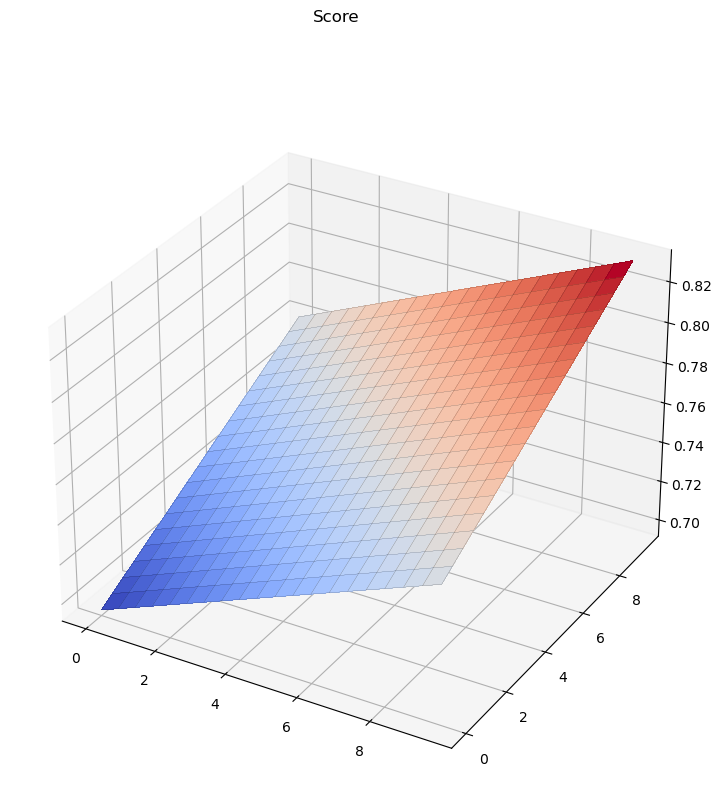

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import math


def value_of_interval(profit, casts):
    return profit * casts

def affin(x, oldMin, oldMax, newMin, newMax):
    x1 = (x - oldMin) / (oldMax - oldMin) * (newMax - newMin) + newMin
    return x1

def get_score(v_back, v_valid):  # meshgrid, or np.array of shape (n,)
    w1 = np.clip(v_back, INTERVAL_VALUE_BOTTOM, INTERVAL_VALUE_TOP)
    w1 = affin(w1, INTERVAL_VALUE_BOTTOM, INTERVAL_VALUE_TOP, 0, 1)
    w2 = np.clip(v_valid, INTERVAL_VALUE_BOTTOM, INTERVAL_VALUE_TOP)
    w2 = affin(w2, INTERVAL_VALUE_BOTTOM, INTERVAL_VALUE_TOP, 0, 1)
    return w1 * w2

def score_of_intervals(profit_back, casts_back, profit_valid, casts_valid, profit_test, casts_test):   # np arrays
    v_back = value_of_interval(profit_back, casts_back)     # (nIntervals,)
    v_valid = value_of_interval(profit_valid, casts_valid)     # (nIntervals,)
    v_test = value_of_interval(profit_test, casts_test)     # (nIntervals,)
    pre_score = get_score(v_back, v_valid)
    test_score = np.clip(v_test, INTERVAL_VALUE_BOTTOM, INTERVAL_VALUE_TOP)
    return pre_score * test_score * 100     # pre_score > 0

fig = plt.figure(figsize=[16, 9])
fig.suptitle('Score')

ax = fig.add_subplot(1, 1, 1, projection='3d')

X = np.arange(-0, 10, 0.5)
Y = np.arange(-0, 10, 0.5)
X, Y = np.meshgrid(X, Y)
Z = get_score(X, Y)

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, rstride=1, cstride=1, linewidth=0, antialiased=False)
ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, colors= 'black', linewidth= .1)
ax.contour(X, Y, Z, 30, lw=3, cmap="autumn_r", linestyles="solid", offset=-1)
ax.contour(X, Y, Z, 30, lw=3, colors="k", linestyles="solid")
# ax.set_zlim(-1, 1)

plt.show()

In [ ]:
class test_class():
    def round_sig(self, x, sig=2):
            # return x
            return round(x, sig-int(math.floor(math.log10(abs(x))))-1)    # domain error for VERY small numbers.
    def __init__(self, class_name, profit_keys, data_batches, nDataRows, nBookies, filepath):
        self.class_name = class_name
        self.profit_keys = profit_keys
        self.data_batches = data_batches
        self.nTests = nDataRows * nBookies
        self.filepath = filepath
        self.profits = {str(key): [] for key in self.profit_keys}
        self.casts = {str(key): [] for key in self.profit_keys}
        self.profits_round = self.casts_round = None
    def removeFile(self):
        files = glob.glob(self.filepath + "*")   # "*.*" may not work
        result = [os.remove(file) for file in files]
    def save(self):
        data_helpers.SaveJsonData([self.profits, self.casts], self.filepath)
    def reset(self):
        self.removeFile()
        # forgot to reset self.profits and self.casts? ------------------------ Check it.
        self.profits = {str(key): [] for key in self.profit_keys}
        self.casts = {str(key): [] for key in self.profit_keys}
        self.save()
    def load(self):
        test = data_helpers.LoadJsonData(self.filepath)
        if test is not None:
            [self.profits, self.casts] = test
    def getLen(self, dict):
        length = None
        try:
            for key, value in dict.items():
                if length is None:
                    length = len(value)
                else:
                    assert len(value) == length
            return length
        except:
            raise Exception("Un-uniform length in  distribution")      

    def len(self):
        assert len(self.profits) == len(self.profit_keys)
        assert len(self.casts) == len(self.profit_keys)
        length = self.getLen(self.profits)
        assert self.getLen(self.casts) == length
        return length

    def append(self, profits, casts):
        _ = self.len()     # for all the asserts.
        assert len(profits) == len(self.profit_keys)
        assert len(casts) == len(self.profit_keys)
        for item_list, item in zip(self.profits.values(), profits): # key by key
            item_list.append(item)

        assert len(casts) == len(self.profit_keys)
        for item_list, item in zip(self.casts.values(), casts): # key by key
            item_list.append(item)

        self.save()

    def find_profit_cast_series(self):
        nSeries = len(tuple(self.profits.values())[0])  # len of the first key's value, which is a list. including zero.
        for v in self.profits.values(): # key by key
            assert len(v) == nSeries
        for v in self.casts.values():   # key by key
            assert len(v) == nSeries
        
        profit_series =  [[v[serial] for v in self.profits.values()] for serial in range(nSeries)] # [ [ profit for _ in profit_keys ] ] * nSeries
        cast_series =  [[v[serial] for v in self.casts.values()] for serial in range(nSeries)] # [ [ cast for _ in profit_keys ] ] * nSeries
        return profit_series, cast_series

    def get_best_product(self, profits, casts):
        best_product = -float('inf') # MIN_PROFIT * 1e6
        for (p, n) in zip(profits, casts):
            if p * n > best_product:
                best_product = p * n
        return best_product
    
    def get_best_product2(self):
        return self.get_best_product(self.profits_round, self.casts_round)

    def get_existing_best_product(self):
        all_profits = []
        for item_list in self.profits.values():
            all_profits += item_list
        all_casts = []
        for item_list in self.casts.values():
            all_casts += item_list
        return self.get_best_product(all_profits, all_casts)
          
    def find_total_profit_groups(self):       
        profit_series, cast_series = self.find_profit_cast_series()
        total_profit_groups = []
        for profits, casts in zip(profit_series, cast_series):
            profit_groups = self.find_profit_groups(profits, casts, sort=False)
            total_profit_groups.append(profit_groups)   # [ [ (product, profit, cast, id_string) for nGroups ] ] * nSeries
        return total_profit_groups
    
    def track_profit_groups(self, total_profit_groups):
        # total_profit_groups: [ [ (product, profit, cast, id_string) for nGroups ] ] * nSeries
        profit_groups_track = None
        nSeries = len(total_profit_groups)
        if nSeries > 0:
            nGroups = len(total_profit_groups[0])
            for profit_groups in total_profit_groups:
                assert len(profit_groups) == nGroups
            profit_groups_track = [[total_profit_groups[series][profit_group] for series in range(nSeries)] for profit_group in range(nGroups)]
        return profit_groups_track  # [ [ (product, profit, cast, id) for _ in range(nSeries)] for _ in range(nGroups) ]
        # profit_groups_track = { profit_groups_track[group][0][3] : [(profit, cast) for _, profit, cast, _ in profit_groups_track[group]] for group in range(nGroups) }
        # return profit_groups_track  # { id : [ (profit, cast) for _ in range(nSeries)] for _ in range(nGroups) }
    
    def find_profit_groups(self, profits, casts, sort=True):
        result = []
        for n1 in range(len(self.profit_keys)):
            for n2 in range(n1, len(self.profit_keys)): 
                # n2 >= n1. profit_keys[n2] >= profit_keys[n1], casts[n2] <= casts[n1]
                if n1 == n2:
                    result.append((profits[n1] * casts[n1], profits[n1], casts[n1], str(self.profit_keys[n1])+"-"))
                else:
                    cast3 = casts[n1] - casts[n2]
                    if cast3 > 0:
                        profit3 = (profits[n1] * casts[n1] - profits[n2] * casts[n2]) / cast3
                    else:
                        profit3 = MIN_PROFIT
                    result.append( (profit3 * cast3, profit3, cast3, str(self.profit_keys[n1])+"-"+str(self.profit_keys[n2])))
        if sort: result.sort(reverse=True)
        return result
    
    def find_profit_groups2(self, sort=True):
        return self.find_profit_groups(self.profits_round, self.casts_round, sort)
    
    def find_profit_groups_elements(self, profits, casts, sort=True):
        result = []
        for n1 in range(len(self.profit_keys)-1):
            n2 = n1 + 1
            cast3 = casts[n1] - casts[n2]
            if cast3 > 0:
                profit3 = (profits[n1] * casts[n1] - profits[n2] * casts[n2]) / cast3
            else:
                profit3 = MIN_PROFIT
            result.append( (profit3 * cast3, profit3, cast3, str(self.profit_keys[n1])+"-"+str(self.profit_keys[n2])))
        if sort: result.sort(reverse=True)
        return result
    
    def find_profit_groups_intervals(self, profits, casts):
        intervals = self.find_profit_groups_elements(profits, casts, sort=False)
        profit = [profit for (_, profit, _, _) in intervals]
        casts = [cast for (_, _, cast, _) in intervals]
        return profit, casts
    
    def find_profit_groups_elements2(self, sort=True):
        return self.find_profit_groups_elements(self.profits_round, self.casts_round, sort)
    
    def print_profit_groups(self, groups, count):
        # groups: [ (product, profit, cast, interval) ] * n
        print(self.class_name, end=', ')
        for (product, profit, cast, interval) in groups:
            print("[{:.5f}, {:.4f}, {}, {}]".format(product, profit, cast, interval), end=', ')
            count -= 1
            if count <= 0:
                print(); break
            
    def show_profit_groups(self, minProduct=0.0):
        total_profit_groups = self.find_total_profit_groups()   # [ [ (product, profit, cast, group_id) for nGroups ] ] * nSeries
        if len(total_profit_groups) < 1: return

        profit_groups_track = self.track_profit_groups(total_profit_groups) # [ [ (product, profit, cast, group_id) for _ in range(nSeries)] for _ in range(nGroups) ]

        nGroups = len(total_profit_groups[0])
        for profit_groups in total_profit_groups:
            assert len(profit_groups) == nGroups
        profit_groups_track = { profit_groups_track[group][0][3] : [(profit, cast) for _, profit, cast, _ in profit_groups_track[group]] for group in range(nGroups) }
        # { group_id : [ (profit, cast) for _ in range(nSeries)] for _ in range(nGroups) }
        
        minCasts = self.nTests; maxCasts = 0
        minProfit = 50.0; maxProfit = MIN_PROFIT
        for key, value in profit_groups_track.items():
            casts = [cast for _, cast in value]
            profits = [profit for profit, _ in value]
            # if profits[-1] * casts[-1] > minProduct:
            if key.endswith('-'):
                if minCasts > min(casts): minCasts = min(casts)
                if maxCasts < max(casts): maxCasts = max(casts)
                if minProfit > min(profits): minProfit = min(profits)
                if maxProfit < max(profits): maxProfit = max(profits)

        step = 5; x = np.arange(minCasts, maxCasts + step, step).reshape(-1, 1)
        step = 0.0005; y = np.arange(minProfit, maxProfit + step, step).reshape(-1, 1)
        X, Y = np.meshgrid(x, y)    # (n, m)
        XY = np.stack((X, Y), axis=-1)  # (n, m, 2)
        Z = XY[:, :, 0] * XY[:, :, 1]   # (n, m)

        if Z.shape[0] >= 2 and Z.shape[1] >= 2:
            sLevels = (0) #, 1, 2, 3, 4, 5) if GUI.loss == 'mean_squared_error' else (0,)
            sColors = ['r'] # GUI.colors[: len(sLevels)]
            nContours = 80
            plt.figure(figsize=(12,8))
            CS0 = plt.contourf(X, Y, Z, nContours, cmap=plt.cm.bone, origin='lower')
            CS = plt.contour(X, Y, Z, CS0.levels, colors=('k'), origin='lower', linewidths=.2)
            plt.contour(X, Y, Z, sLevels, colors=sColors, origin='lower', linewidths=.5)    
            plt.clabel(CS, fmt='%1.1f', colors='c', fontsize=8, inline=True)

        for key, value in profit_groups_track.items():
            casts = [cast for _, cast in value]
            profits = [profit for profit, _ in value]
            # if profits[-1] * casts[-1] > minProduct:
            if key.endswith('-'):
                plt.plot(casts, profits, label=key, marker='o', lw=0.5)
                plt.plot(casts[-1], profits[-1], marker='o', color='k')
                plt.plot(casts[-1], profits[-1], marker='x', color='w')
        plt.legend(loc='best')
        plt.xlabel('casts')
        plt.ylabel('profit')
        plt.grid(True)

        plt.show()

    def show(self, ax):
        colors = ['black', 'firebrick', 'darkgreen', 'c', 'blue', 'blueviolet', 'magenta', 'maroon', "yellowgreen", 'cadetblue', 'purple', 'c', 'blue']

        gmin = MIN_PROFIT - 1.0; gmax = MIN_PROFIT
        all_profits = []
        for item_list in self.profits.values():
            all_profits += item_list
        if len(all_profits) > 0:
            gmin = min(all_profits); gmax = max(all_profits)

        _min = 0.0; _max = self.nTests        
        # _min = 0.0; _max = 1.0
        # all_nBettings = []
        # for item_list in self.nBettings.values():
        #     all_nBettings += item_list
        # if len(all_nBettings) > 0:
        #     _min = min(all_nBettings); _max = max(all_nBettings)
        
        legends = []
        for item_list, color, key in zip(self.profits.values(), colors[:len(self.profit_keys)], self.profit_keys):
            # print(item_list, color, key)
            ax.plot(item_list, color=color, linewidth=0.7)
            legends.append("> " + str(key))
        # print(legends)

        for item_list, color in zip(self.casts.values(), colors[:len(self.profit_keys)]):
            item_list = [ (item-_min)/(_max-_min+1e-9) * (gmax-gmin) + gmin for item in item_list]
            ax.plot(item_list, color=color, linestyle='--', linewidth=0.7)

        ax.legend(legends, loc='upper left')
        ax.grid(True)
        ax.set_title(TEST_ID + ": avg_profit and scaled nBettings per profit threshold key. max: {}".format(gmax))
        ax.set_ylabel('loss')
        ax.set_xlabel('epoch', loc='right')

                # KEEP INSIDE profits_back, casts_back = backtest_with_dataset(back_batches, backtest.profit_keys),
    def run_and_append_test(self):
        self.profits_round, self.casts_round = backtest_with_dataset(self.data_batches, self.profit_keys)
        self.append(self, self.profits_round, self.casts_round)


In [ ]:

checkpointPath = os.path.join(countryDirPath, '_checkpoints', TEST_ID + '_weights')
checkpointPathBest = os.path.join(countryDirPath, '_checkpoints', TEST_ID + '_weights_best')
CheckpointPathBestBase = os.path.join(countryDirPath, '_checkpoints', BASE_TEST_ID + '_weights_best')
historyPath = os.path.join(countryDirPath, '_checkpoints', TEST_ID + '_history.json')
backtestPath = os.path.join(countryDirPath, '_checkpoints', TEST_ID + '_backtest.json')
validtestPath = os.path.join(countryDirPath, '_checkpoints', TEST_ID + '_validtest.json')
testtestPath = os.path.join(countryDirPath, '_checkpoints', TEST_ID + '_testtest.json')

history = history_class(historyPath)
backtest = test_class("back", PROFIT_KEYS, back_batches, len(back_ds), len(model_1x2.bookies), backtestPath)
validtest = test_class("vald", PROFIT_KEYS, valid_batches, len(valid_ds), len(model_1x2.bookies), validtestPath)
testtest = test_class("test", PROFIT_KEYS, test_batches, len(test_ds), len(model_1x2.bookies), testtestPath)

def removeFile(path):
    files = glob.glob(path + "*")   # "*.*" may not work
    result = [os.remove(file) for file in files]
    return

if RESET_HISTORY:
    removeFile(checkpointPath)
    removeFile(checkpointPathBest)
    history.reset()
    backtest.reset()
    validtest.reset()
    testtest.reset()

history.load()
backtest.load()
validtest.load()
testtest.load()

print("history: ", history.history['loss'])

if BASE_TEST_ID != '':      # whether training or infering. BASE_TEST_ID can even be this one.
    try: 
        model_1x2.load_weights(CheckpointPathBestBase)
        print('The best model of ' + BASE_TEST_ID + ' loaded.')
    except:
        print('Failed to load the best model of ' + BASE_TEST_ID)
else:
    if TRAIN_MODE:          # not the best.
            try: 
                model_1x2.load_weights(checkpointPath)
                print('The latest model of ' + TEST_ID + ' loaded.')
            except:
                print('Failed to load the latest model of ' + TEST_ID)
    else:                   # best one
        try: 
            model_1x2.load_weights(checkpointPathBest)
            print('The best model of ' + TEST_ID + ' loaded.')
        except:
            print('Failed to load the best model of ' + TEST_ID)

history:  []
Failed to load the latest model of X.29


In [ ]:
global_step = tf.Variable(history.len(), dtype=tf.float32, trainable=False)
starter_learning_rate = STARTING_LEARNING_RATE
# It will reach starter_learning_rate * 0.1 when len(history.history['loss']) reaches 30.
learning_rate = tf.compat.v1.train.exponential_decay(starter_learning_rate, global_step, EXAMPLE_LEARNING_STEP, EXAMPLE_LEARNING_RATE/STARTING_LEARNING_RATE, staircase=False)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-12)

In [ ]:
@tf.function
def train_step(x, y):
    
    with tf.GradientTape() as tape:
        outputs = model_1x2(x, training=True)  # [ (batch, 1), (batch, nQueries) for _ in bookies]
        loss_value = model_1x2.loss(y, outputs)
    
    grads = tape.gradient(loss_value, model_1x2.trainable_weights)
    optimizer.apply_gradients(zip(grads, model_1x2.trainable_weights))
    # recall_object.update_state(y, logits)
    # precision_object.update_state(y, logits)
    return loss_value

@tf.function
def find_loss_for_step(x, y):
    outputs = model_1x2(x, training=False)  # [ (batch, 1), (batch, nQueries) for _ in bookies]
    loss_value = model_1x2.loss(y, outputs)
    # recall_object.update_state(y, val_logits)
    # precision_object.update_state(y, val_logits)
    return loss_value

# @tf.function  #-------------------- Weird: no work.
def find_loss_for_dataset(dataset):
    n = 0
    val_loss = tf.Variable(0.0, dtype=tf.float32)
    for step, ((baseId, sequence, base_bb, baseDateDetails, mask), (base_label, seq_len_org)) in enumerate(dataset):
        x = (sequence, base_bb, baseDateDetails, mask); y = base_label
        n += 1
        val_loss = val_loss * (n-1) / n + find_loss_for_step(x, y) / n   ###
    return val_loss

In [ ]:
focus_interval_id = focus_scores = focus_back = focus_valid = focus_test = None

def get_interval_scores(profits_back, casts_back, profits_valid, casts_valid, profits_test, casts_test):
    p_back, c_back = backtest.find_profit_groups_intervals(profits_back, casts_back)
    p_valid, c_valid = validtest.find_profit_groups_intervals(profits_valid, casts_valid)
    p_test, c_test = testtest.find_profit_groups_intervals(profits_test, casts_test)

    p_back = np.array(p_back, dtype=np.float32)
    c_back = np.array(c_back, dtype=np.float32)
    p_valid = np.array(p_valid, dtype=np.float32)
    c_valid = np.array(c_valid, dtype=np.float32)
    p_test = np.array(p_test, dtype=np.float32)
    c_test = np.array(c_test, dtype=np.float32)
    scores = score_of_intervals(p_back, c_back, p_valid, c_valid, p_test, c_test)   # np arrays
    
    id = np.argmax(scores)
    back = (p_back[id]*c_back[id], p_back[id], c_back[id])
    valid = (p_valid[id]*c_valid[id], p_valid[id], c_valid[id])
    test = (p_test[id]*c_test[id], p_test[id], c_test[id])

    return id, list(scores), back, valid, test

def show_steps(epoch, step, loss, samples_seen, learning_rate):
    # recall = recall_object.result()
    # precision = precision_object.result()
    # print("epoch: {}, step: {}, loss: {}, recall: {}, precision: {}, samples_seen: {}".
    #       format(epoch, step, float(loss_value), recall, precision, (step + 1) * hParams.batch_size))
    print("epoch: {}, step: {}, loss: {}, samples_seen: {}, learning_rate: {:.5e}                  ".
            format(epoch, step, float(loss), samples_seen, learning_rate), end='\r')
    # recall_object.reset()
    # precision_object.reset()

def print_test(epoch, train_loss, val_loss, learning_rate, profits_back, casts_back, profits_valid, casts_valid, profits_test, casts_test):
    print("epoch: {}, loss: {}, val_loss: {}, learning_rate: {:.5e}, profit: {}, casts: {}".format(epoch, float(train_loss), float(val_loss), learning_rate, profits_valid, casts_valid))
        
    pGroups_back = backtest.find_profit_groups(profits_back, casts_back)
    backtest.print_profit_groups(pGroups_back, 10)
    pGroups_valid = validtest.find_profit_groups(profits_valid, casts_valid)
    validtest.print_profit_groups(pGroups_valid, 10)
    pGroups_test = testtest.find_profit_groups(profits_test, casts_test)
    testtest.print_profit_groups(pGroups_test, 10)

    pGroups_back = backtest.find_profit_groups_elements(profits_back, casts_back, sort=False)
    backtest.print_profit_groups(pGroups_back, len(backtest.profit_keys)-1)
    pGroups_valid = validtest.find_profit_groups_elements(profits_valid, casts_valid, sort=False)
    validtest.print_profit_groups(pGroups_valid, len(validtest.profit_keys)-1)
    pGroups_test = testtest.find_profit_groups_elements(profits_test, casts_test, sort=False)
    testtest.print_profit_groups(pGroups_test, len(testtest.profit_keys)-1)

    values_back = np.array([value for (_, value, _, _) in pGroups_back], dtype=np.float32); norm_back = np.sqrt(np.sum(values_back * values_back))
    values_valid = np.array([value for (_, value, _, _) in pGroups_valid], dtype=np.float32); norm_valid = np.sqrt(np.sum(values_valid * values_valid))
    values_test = np.array([value for (_, value, _, _) in pGroups_test], dtype=np.float32); norm_test = np.sqrt(np.sum(values_test * values_test))
    back_valid = np.sum(values_back * values_valid) / (norm_back * norm_valid)
    valid_test = np.sum(values_valid * values_test) / (norm_valid * norm_test)
    test_back = np.sum(values_test * values_back) / (norm_test * norm_back)
    average = (back_valid + valid_test + test_back) / 3
    print("Cosign simularity: back-valid, valid-test, test-back, average : {:.5f}, {:.5f}, {:.5f}, {:.5f}".format(back_valid, valid_test, test_back, average))

    return

def accumulate(backtests, compound=False):
    initial = 1.0
    sum = initial; minS = sum; maxS = sum
    for (bookie, gameId, profit) in backtests:
        sum += (profit * ( max(1, sum) if compound else 1))
        if sum < minS: minS = sum
        if sum > maxS: maxS = sum
    return sum, minS, maxS

def conclude_train_epoch(epoch, train_loss, val_loss, learning_rate, profits_back, casts_back, profits_valid, casts_valid, profits_test, casts_test, playBack=False):
    global focus_interval_id, focus_scores, focus_back, focus_valid, focus_test

    print_test(epoch, train_loss, val_loss, learning_rate, profits_back, casts_back, profits_valid, casts_valid, profits_test, casts_test)  # read only
    id, scores, back, valid, test = get_interval_scores(profits_back, casts_back, profits_valid, casts_valid, profits_test, casts_test) # read only

    print("______interval: ", id, ", best score: ", scores[id], ", scores: ", ', '.join('{:.5f}'.format(f) for f in scores),  ", back valid test: ", back, valid, test)

    if not playBack: model_1x2.save_weights(checkpointPath)
    
    # if playBack:
    #     epoch, key_a, key_b, backtests = history.get_backtests(epoch)
    # else:
    key_a = PROFIT_KEYS[id]; key_b = PROFIT_KEYS[id+1]
    backtests = backtest_event_wise_with_dataset(backtest_batches, key_a, key_b)  # [(bookie, gameId, profit) for ...]
    history.append_backtests(epoch, key_a, key_b, backtests)

    compound = False
    sum, minS, maxS = accumulate(backtests, compound=compound)
    print('compound, acc, minAcc, maxAcc: ', compound, sum, minS, maxS)
    compound = True
    sum, minS, maxS = accumulate(backtests, compound=compound)
    print('compound, acc, minAcc, maxAcc: ', compound, sum, minS, maxS)

    if scores[id] > history.get_max_best_interval_scores(epoch):
        focus_interval_id, focus_scores, focus_back, focus_valid, focus_test = id, scores, back, valid, test
        if not playBack: model_1x2.save_weights(checkpointPathBest)
        print("----------------------------------------------------------------------------------------------------- focus and best checkpoint updated")

        if not playBack: history.append_backtests(epoch, key_a, key_b, backtests)

    # call this later than get_max_best_interval_scores.
    if playBack: history.replace_best_interval_score(epoch, scores[id]) 

    if not playBack:
        history.append(train_loss, val_loss, learning_rate, id, scores[id])
        backtest.append(profits_back, casts_back)
        validtest.append(profits_valid, casts_valid)
        testtest.append(profits_test, casts_test)


In [ ]:
backtest.show_profit_groups(minProduct=0.0)

In [ ]:
validtest.show_profit_groups(minProduct=0.0)

In [ ]:
testtest.show_profit_groups(minProduct=0.0)

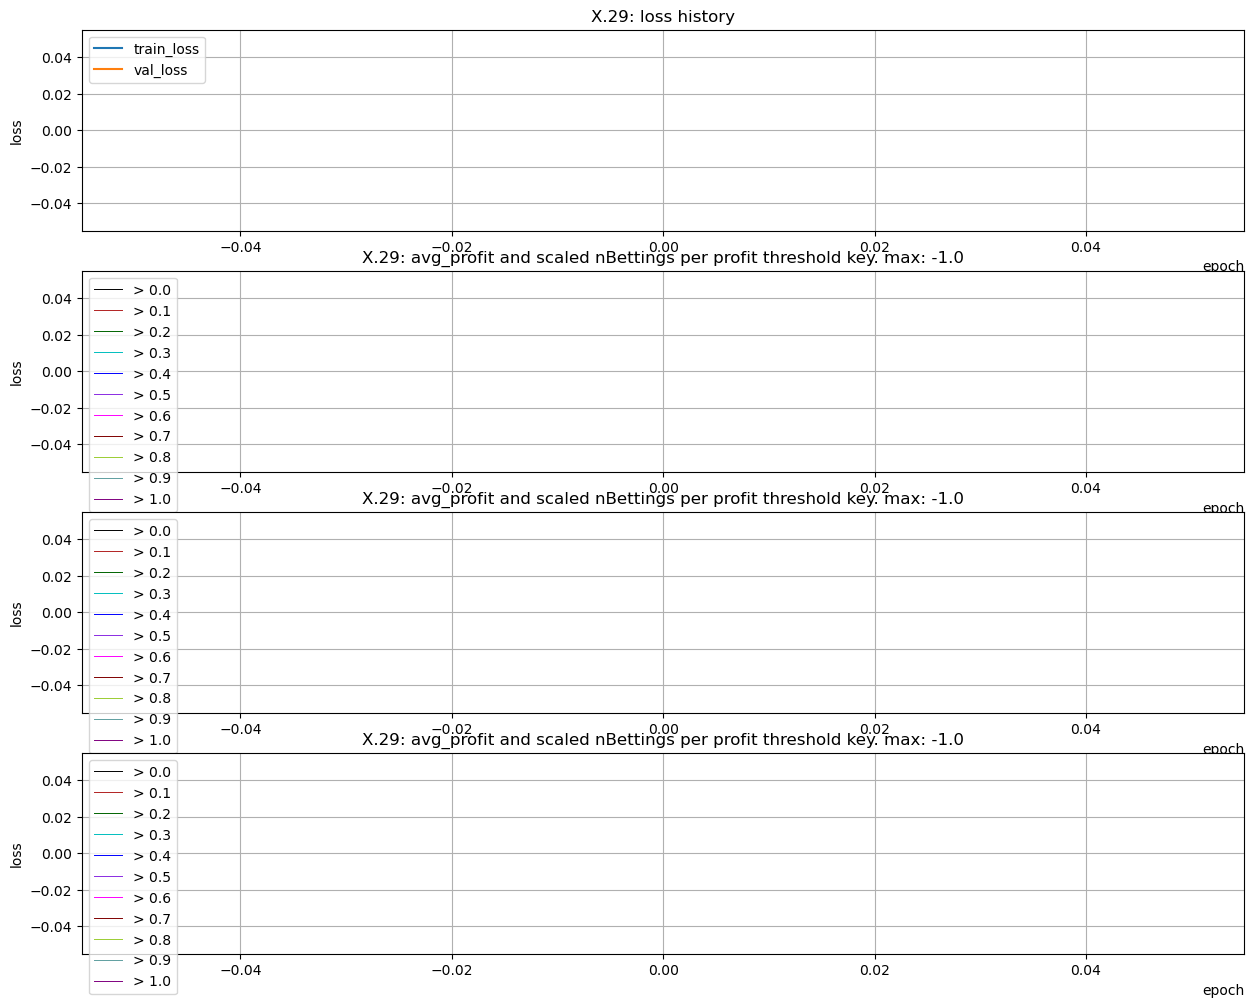

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15,12))
history.show(axes[0]); backtest.show(axes[1]); validtest.show(axes[2]); testtest.show(axes[3]); plt.show()

In [ ]:
#-------------------------------------------------------------------------------------------------

profit_series_back, cast_series_back = backtest.find_profit_cast_series()
profit_series_valid, cast_series_valid = validtest.find_profit_cast_series()
profit_series_test, cast_series_test = testtest.find_profit_cast_series()

epoch = 0
for train_loss, val_loss, learning_rate, profits_back, casts_back, profits_valid, casts_valid, profits_test, casts_test \
    in zip(history.history['loss'], history.history['val_loss'],  history.history['learning_rate'], profit_series_back, cast_series_back, profit_series_valid, cast_series_valid, profit_series_test, cast_series_test):
    conclude_train_epoch(epoch, train_loss, val_loss, learning_rate, profits_back, casts_back, profits_valid, casts_valid, profits_test, casts_test, playBack = True)
    epoch += 1

In [ ]:
def train(epochs):
    epochs = epochs
    global global_step
    for epoch in range(history.len(), history.len() + epochs):
        start_time = time.time()
        global_step.assign(history.len())
        learning_rate = optimizer.lr.numpy()
        # history.show(axes[0]); backtest.show(axes[1]); plt.show()
        n = 0; loss = tf.Variable(0.0, dtype=tf.float32); samples_seen = 0
        m = 0; train_loss = 0.0
        
        train_batches = apply_train_pipeline(train_ds)      # the pipeline includes suffle.
        for step, ((baseId, sequence, base_bb, baseDateDetails, mask), (base_label, seq_len_org)) in enumerate(train_batches):
            x = (sequence, base_bb, baseDateDetails, mask); y = base_label
            samples_seen += sequence.shape[0]
            batch_loss = train_step(x, y)
            n += 1; loss = loss * (n-1)/n + batch_loss/n
            m += 1; train_loss = train_loss * (m-1)/m + batch_loss/m

            if step % 50 == 0:
                show_steps(epoch, step, loss, samples_seen, learning_rate)
                n = 0; loss = 0.0

        show_steps(epoch, step, loss, samples_seen, learning_rate)  # closing show

        val_loss = find_loss_for_dataset(valid_batches)
        profits_back, casts_back = backtest_with_dataset(back_batches, backtest.profit_keys)
        profits_valid, casts_valid = backtest_with_dataset(valid_batches, validtest.profit_keys)
        profits_test, casts_test = backtest_with_dataset(test_batches, testtest.profit_keys)
        conclude_train_epoch(epoch, train_loss, val_loss, learning_rate, profits_back, casts_back, profits_valid, casts_valid, profits_test, casts_test, playBack=False)

        print("time taken: {:.1f}m, learning_rate: {:.5e}   ".format((time.time()-start_time)/60, learning_rate))

if TRAIN_MODE: train(50)    #--------------------------------------------------------------------------------------

epoch: 0, loss: 0.07070396095514297, val_loss: 0.06419867277145386, learning_rate: 2.00000e-06, profit: [-0.07604957449501444, -0.08521014002070844, -0.08374718981855488, -0.13125419496528565, -0.17151537520418825, -0.1742501049419912, -0.1843047796527325, -0.2591406308330487, -0.2885484170476232, -0.3951832813375136, -0.4050752104145207], casts: [1844, 968, 616, 403, 304, 238, 181, 138, 109, 85, 73]
back, [-0.93656, -0.0780, 12, 0.8-0.9], [-1.00234, -0.0205, 49, 0.5-0.6], [-2.69329, -0.1036, 26, 0.7-0.8], [-3.62985, -0.0955, 38, 0.7-0.9], [-4.79084, -0.0656, 73, 0.4-0.5], [-5.79318, -0.0475, 122, 0.4-0.6], [-8.10297, -0.5788, 14, 0.9-1.0], [-9.03953, -0.3477, 26, 0.8-1.0], [-11.73282, -0.2256, 52, 0.7-1.0], [-12.02091, -0.3163, 38, 0.6-0.7], 
vald, [2.40224, 0.0559, 43, 0.6-0.7], [2.13880, 0.0891, 24, 0.8-0.9], [1.30717, 0.0061, 213, 0.2-0.3], [0.55241, 0.0018, 312, 0.2-0.4], [0.23141, 0.0024, 96, 0.6-0.9], [-0.75477, -0.0076, 99, 0.3-0.4], [-1.88129, -0.0523, 36, 0.8-1.0], [-1.90739,

In [ ]:
interval_a = 0.7    # Choose one
interval_b = 0.8    # Choose one

if not TRAIN_MODE:      # just sketch
    # df_grown gets to be the existing df_grown, because the train_mode if False.
    df_total, df_new = df_grown, df_new = data_helpers.get_grown_and_new_from_football_data(countryDirPath, Required_Non_Odds_cols, NUMBER_BOOKIES, train_mode = TRAIN_MODE, skip=False)
    df_white = df_new
    df_black = data_helpers.read_excel(path)

    df_total = df_total; df_search = df_new
    additional_id_to_ids = data_helpers.fixture_id_to_ids_uk_maxflow(countryDirPath, targetLength, minCurrent, sinceDaysAgo, qualityPct, conductance365, df_total, df_search, chooseDivs=chooseDivs)
    
    ds_path = os.path.join(countryDirPath, '_datasets', id_to_ids_filename + '-dataset-inference')

    if os.path.exists(ds_path):
        ds = tf.data.Dataset.load(ds_path)
    else:
        ds = generate_dataset_uk(df_total, additional_id_to_ids, tokenizer_team, std_params, train_mode=False)  #-----------------                                                                          #-----------------
        tf.data.Dataset.save(ds, ds_path)       # This is the true line by which the dataset generator gets to work.
        ds = tf.data.Dataset.load(ds_path)      # Weird, this line is required. len(ds) would have no value!!!

    ds_inference = apply_test_pipeline(ds)
    stake_vectors = inference_with_dataset(ds_inference, interval_a, interval_b) # (batch, nBookies, nQueries)

